# COVID-19 data exploration and monitoring
With credits to Saeed Amen at Cuemacro (www.cuemacro.com)

With inspiration from Saeed, this notebook intends to explore and visualise the trends of case growth in COVID-19 cases. In particular, I hope to understand more about the density of the infections relative to the population of a particular area.

Currently, the sources for this notebook come from the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) repository at https://github.com/CSSEGISandData/COVID-19, the source for the data in [another dashboard](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

This repository contains data in multiple forms. As of the time of writing, there are WHO situation reports as well as data from the CSSE COVID-19 dataset. In each of these datasets, there are daily snapshot reports, as well as the time series of each of the datasets. Lastly, there is a directory containing archived data. The CSSE COVID-19 dataset also includes a look-up table for ISO FIPS UID.

In [1]:
REPO_PATH = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
CSSE_DATA_PATH = REPO_PATH + "csse_covid_19_data/"
TIME_SERIES_PATH = CSSE_DATA_PATH + "csse_covid_19_time_series/"

In [2]:
CSV_URL = {}
CSV_URL['CONFIRMED'] = "time_series_covid19_confirmed_global.csv"
CSV_URL['DEATHS'] = "time_series_covid19_deaths_global.csv"
CSV_URL['RECOVERED'] = "time_series_covid19_recovered_global.csv"
CSV_URL['US_CONFIRMED'] = "time_series_covid19_confirmed_US.csv"
CSV_URL['US_DEATHS'] = "time_series_covid19_deaths_US.csv"

In [3]:
# download OECD information
OECD_CSV = "https://stats.oecd.org/sdmx-json/data/DP_LIVE/.POP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en"

# World Bank population data
WORLDBANK_POP_ZIP = "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"

In [4]:
import datetime as dt
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile as zf
import io
import requests

print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
#print(f"Zipfile version: {zf.__version__}")

%matplotlib inline

Numpy version: 1.18.1
Pandas version: 1.0.3


In [5]:
# check renderer for plotly
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']

## Confirmed cases

Research questions to be addressed:
1. Has the pace of infections slowed in the US and other (selected) countries?
2. Is there a "natural" proportion of the population which will be infected before it tails off?
3. How can I identify "regimes" of infection transmission?

In [6]:
df_us_confirmed = (pd.read_csv(TIME_SERIES_PATH + CSV_URL['US_CONFIRMED'])
                   .rename(columns={'Long_': 'Long',
                                    'Country_Region': 'Country/Region',
                                    'Province_State': 'Province/State'
                                   })
                  )
df_confirmed = pd.read_csv(TIME_SERIES_PATH + CSV_URL['CONFIRMED'])

In [7]:
set(df_us_confirmed.columns) - set(df_confirmed.columns)

{'Admin2', 'Combined_Key', 'FIPS', 'UID', 'code3', 'iso2', 'iso3'}

In [8]:
set(df_confirmed.columns) - set(df_us_confirmed.columns)

set()

In [9]:
def _process_columns(col_name):
        try: 
            return dt.datetime.strptime(col_name, '%m/%d/%y').date()
        except ValueError:
            try:
                return dt.datetime.strptime(col_name, '%m/%d/%Y').date()
            except ValueError:
                return col_name

In [10]:
df_by_country = (pd.pivot_table(df_confirmed.drop(columns=['Lat', 'Long', 'Province/State']),
                                index=['Country/Region'],
                                aggfunc=np.sum
                               )
                 .rename(columns=_process_columns)
                 .transpose()
                 .sort_index()
                )

## Global

In [11]:
def cases_and_rate(series):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300) 
    ax_2 = ax.twinx()
    ax.set_ylabel('Number of cases')
    ax_2.set_ylabel('pct_change')
    ax.plot(series)
    ax_2.plot(series.pct_change(),
              color='tab:red'
             )
    plt.show()

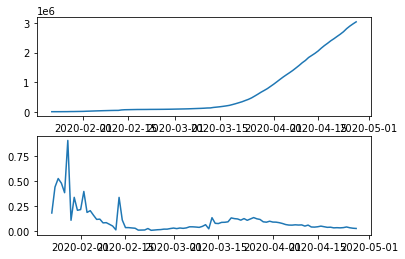

In [12]:
GL_fig, GL_axs = plt.subplots(2)
GL_axs[0].plot(df_by_country.sum(axis=1))
GL_axs[1].plot(df_by_country.sum(axis=1).pct_change())

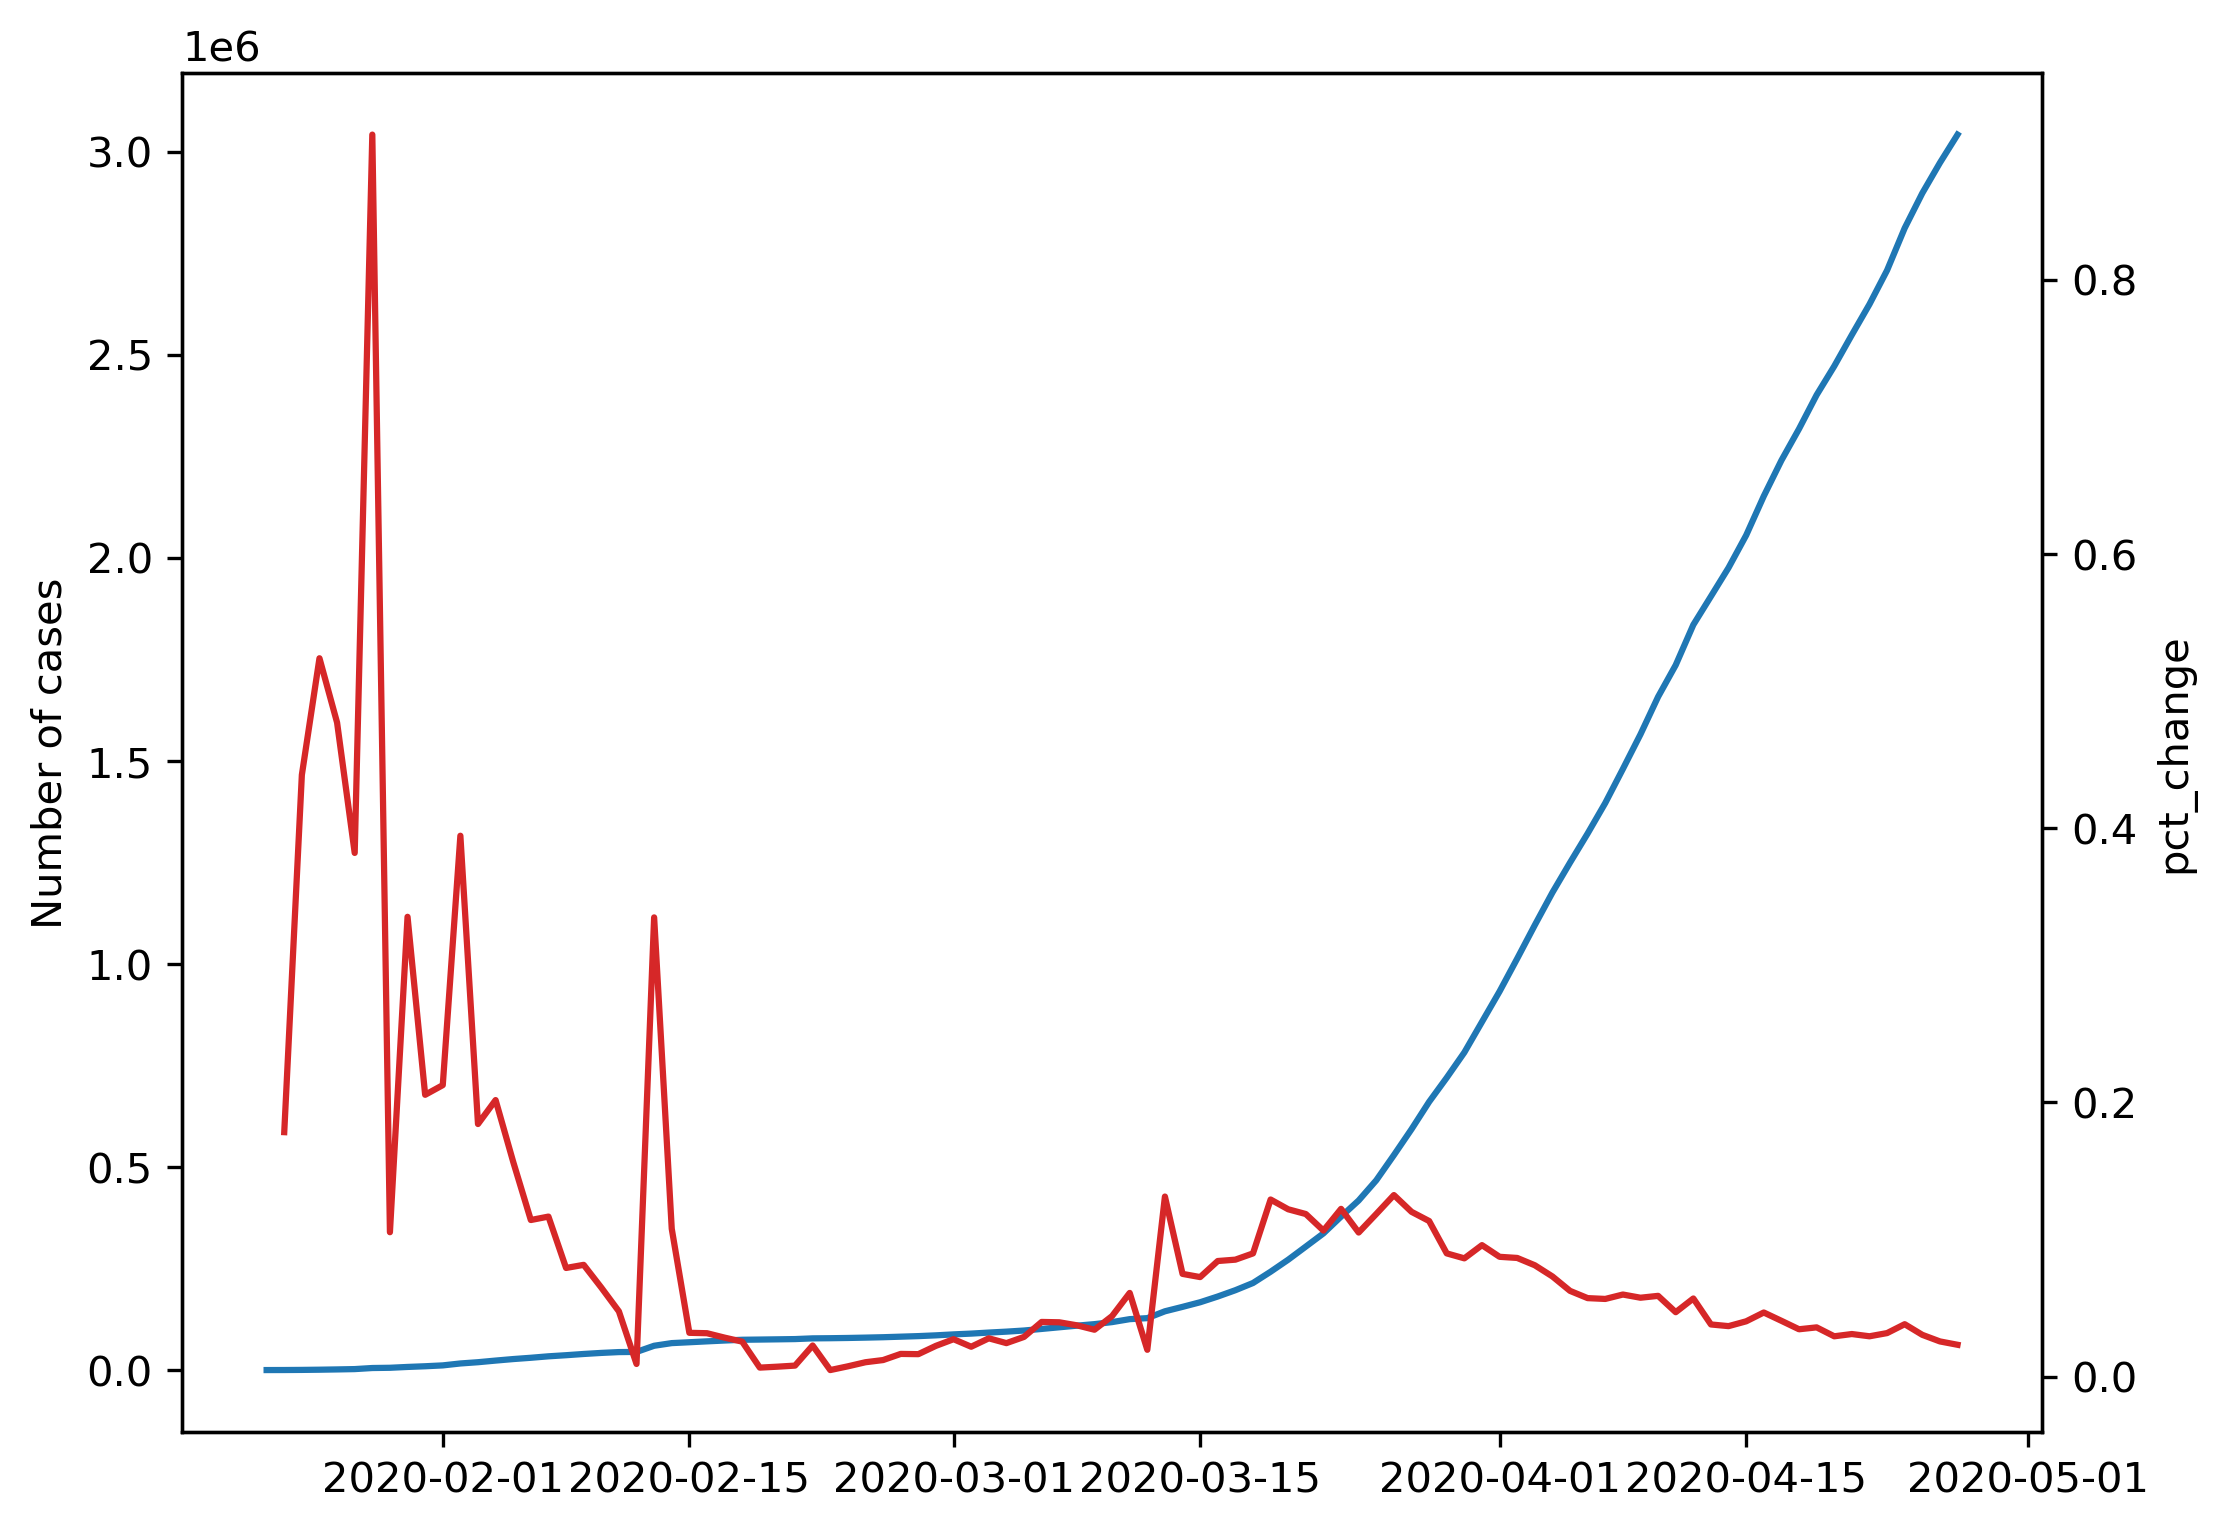

In [13]:
cases_and_rate(df_by_country.sum(axis=1))

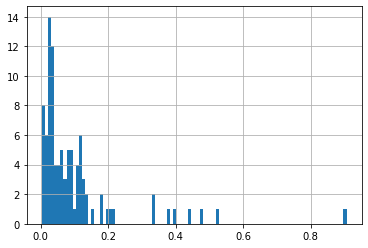

In [14]:
df_by_country.sum(axis=1).pct_change().hist(bins=100)

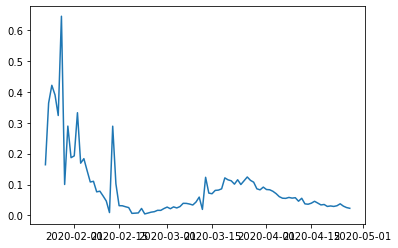

In [15]:
np.log(df_by_country.sum(axis=1)).diff().plot()

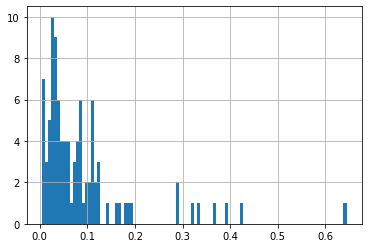

In [16]:
np.log(df_by_country.sum(axis=1)).diff().hist(bins=100)

## United Kingdom

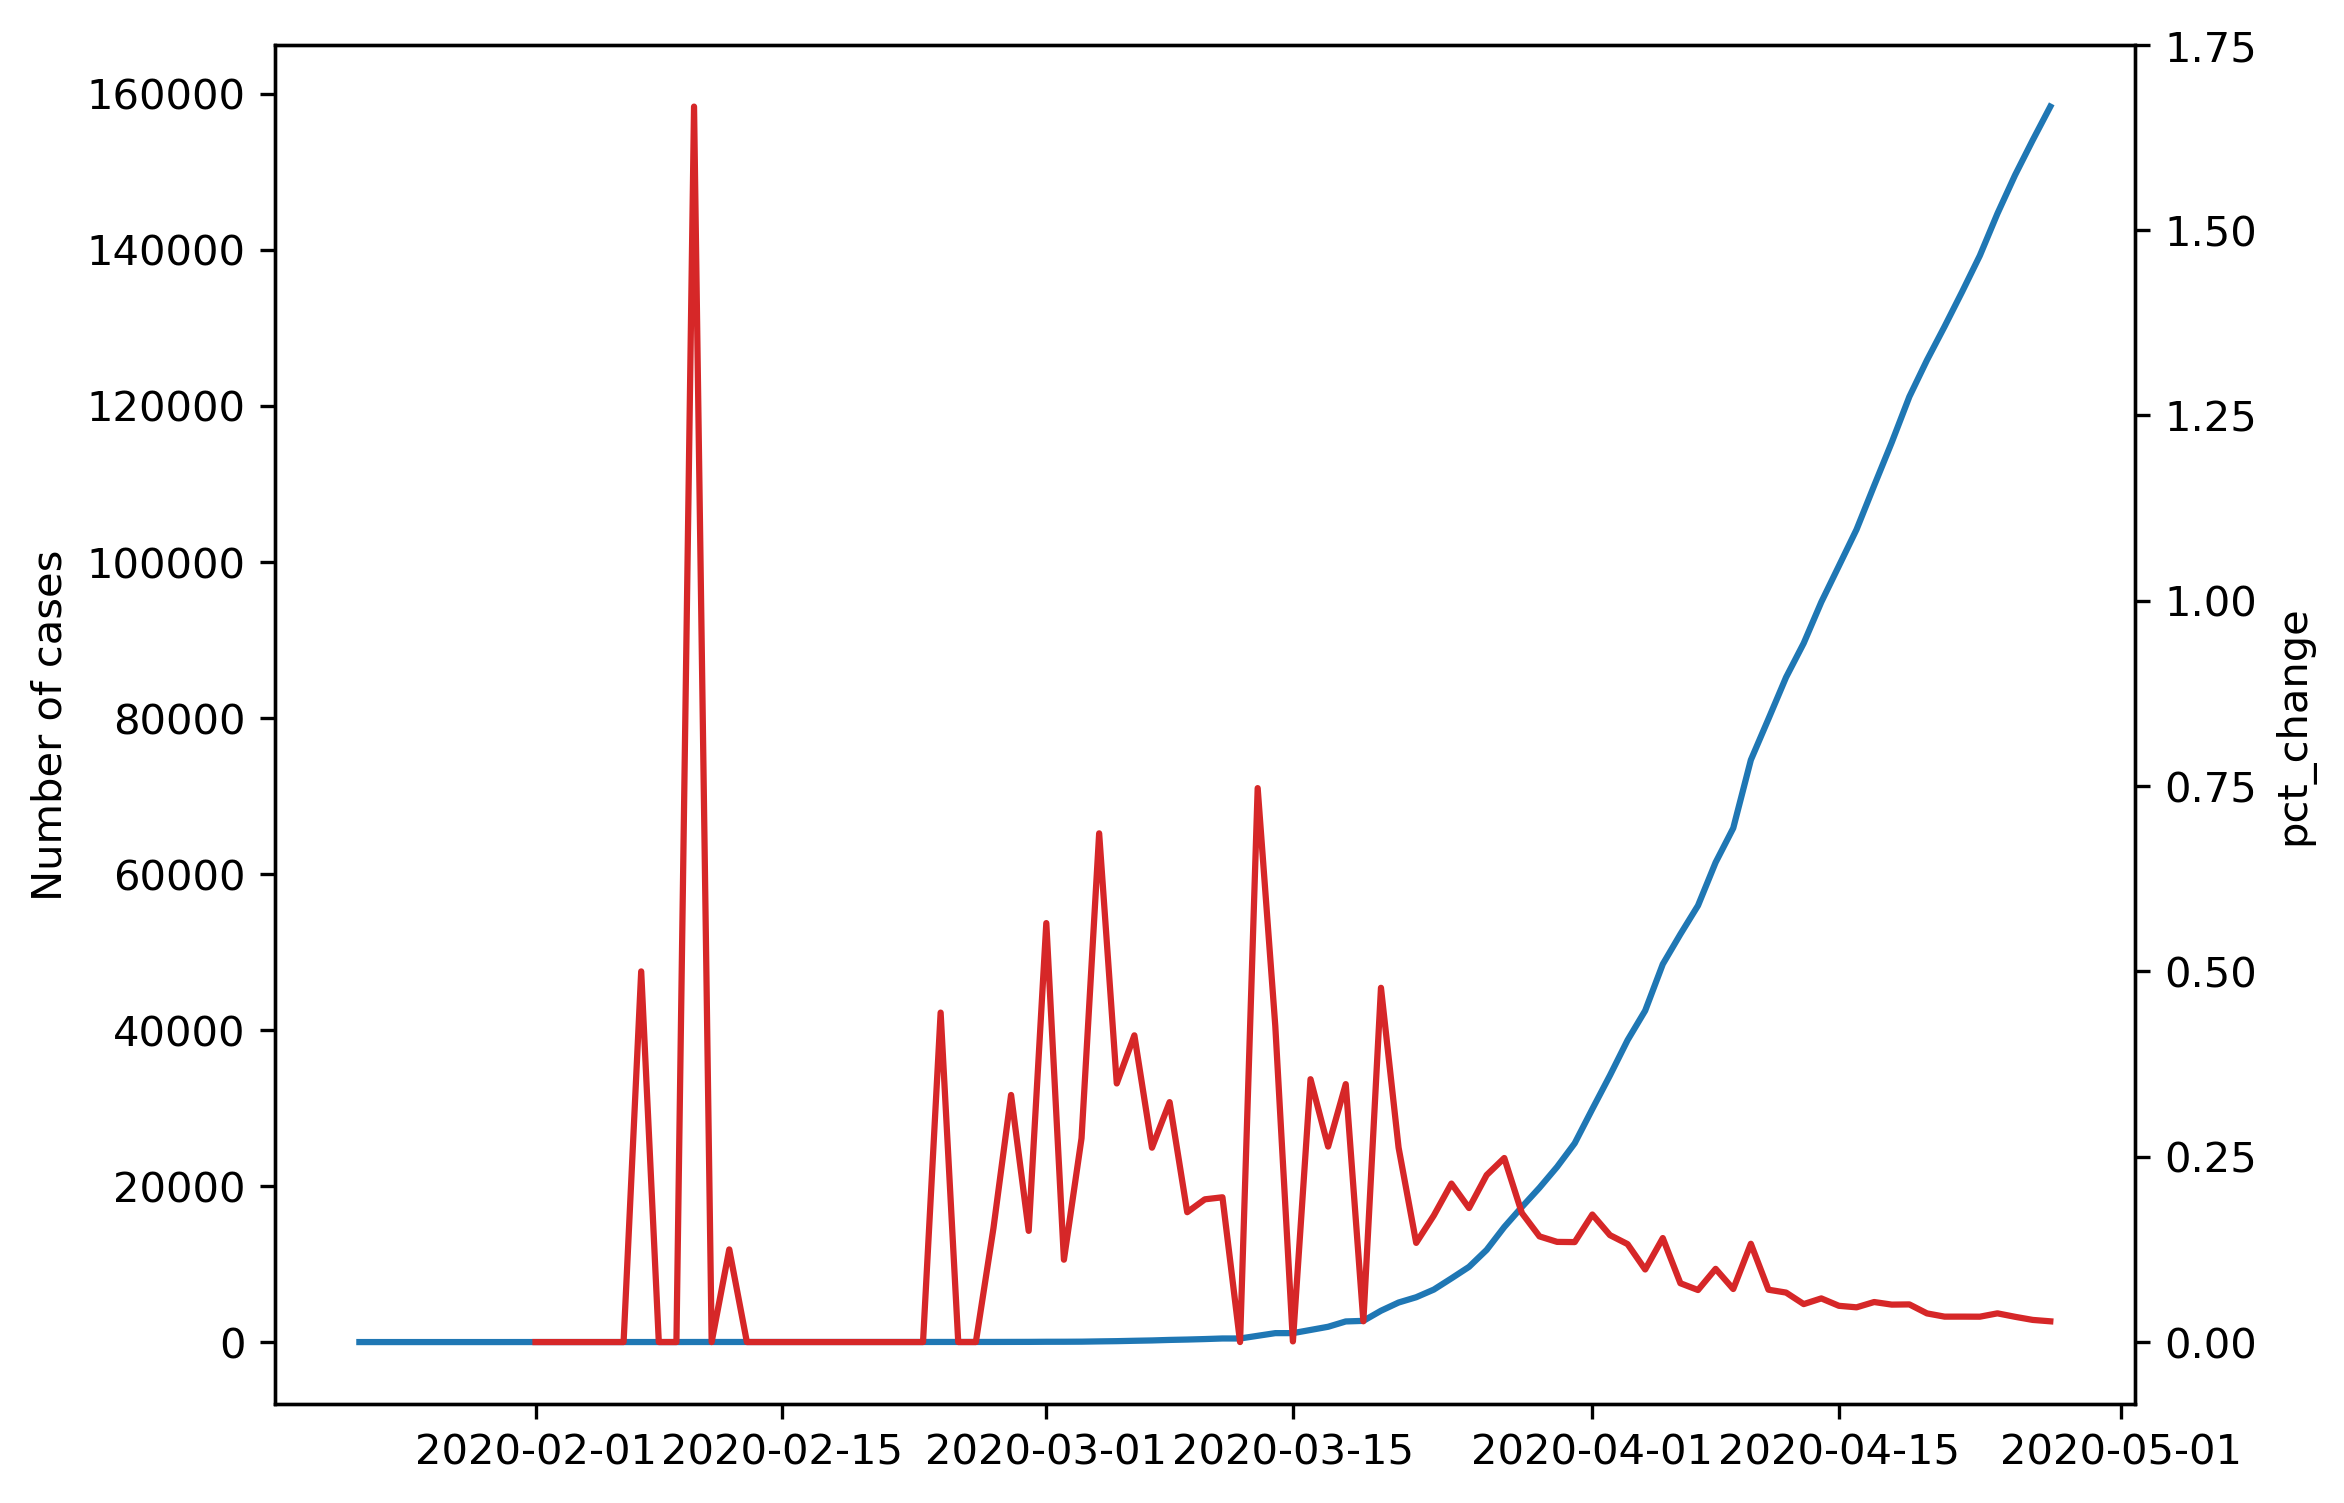

In [17]:
cases_and_rate(df_by_country['United Kingdom'])

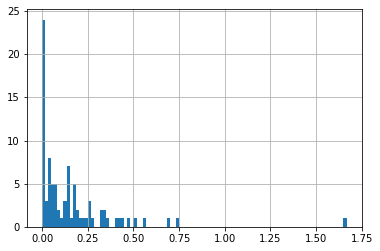

In [18]:
(df_by_country['United Kingdom'].pct_change()
 .replace([np.inf, -np.inf], np.nan)
 .dropna()
 .hist(bins=100)
)

## Singapore

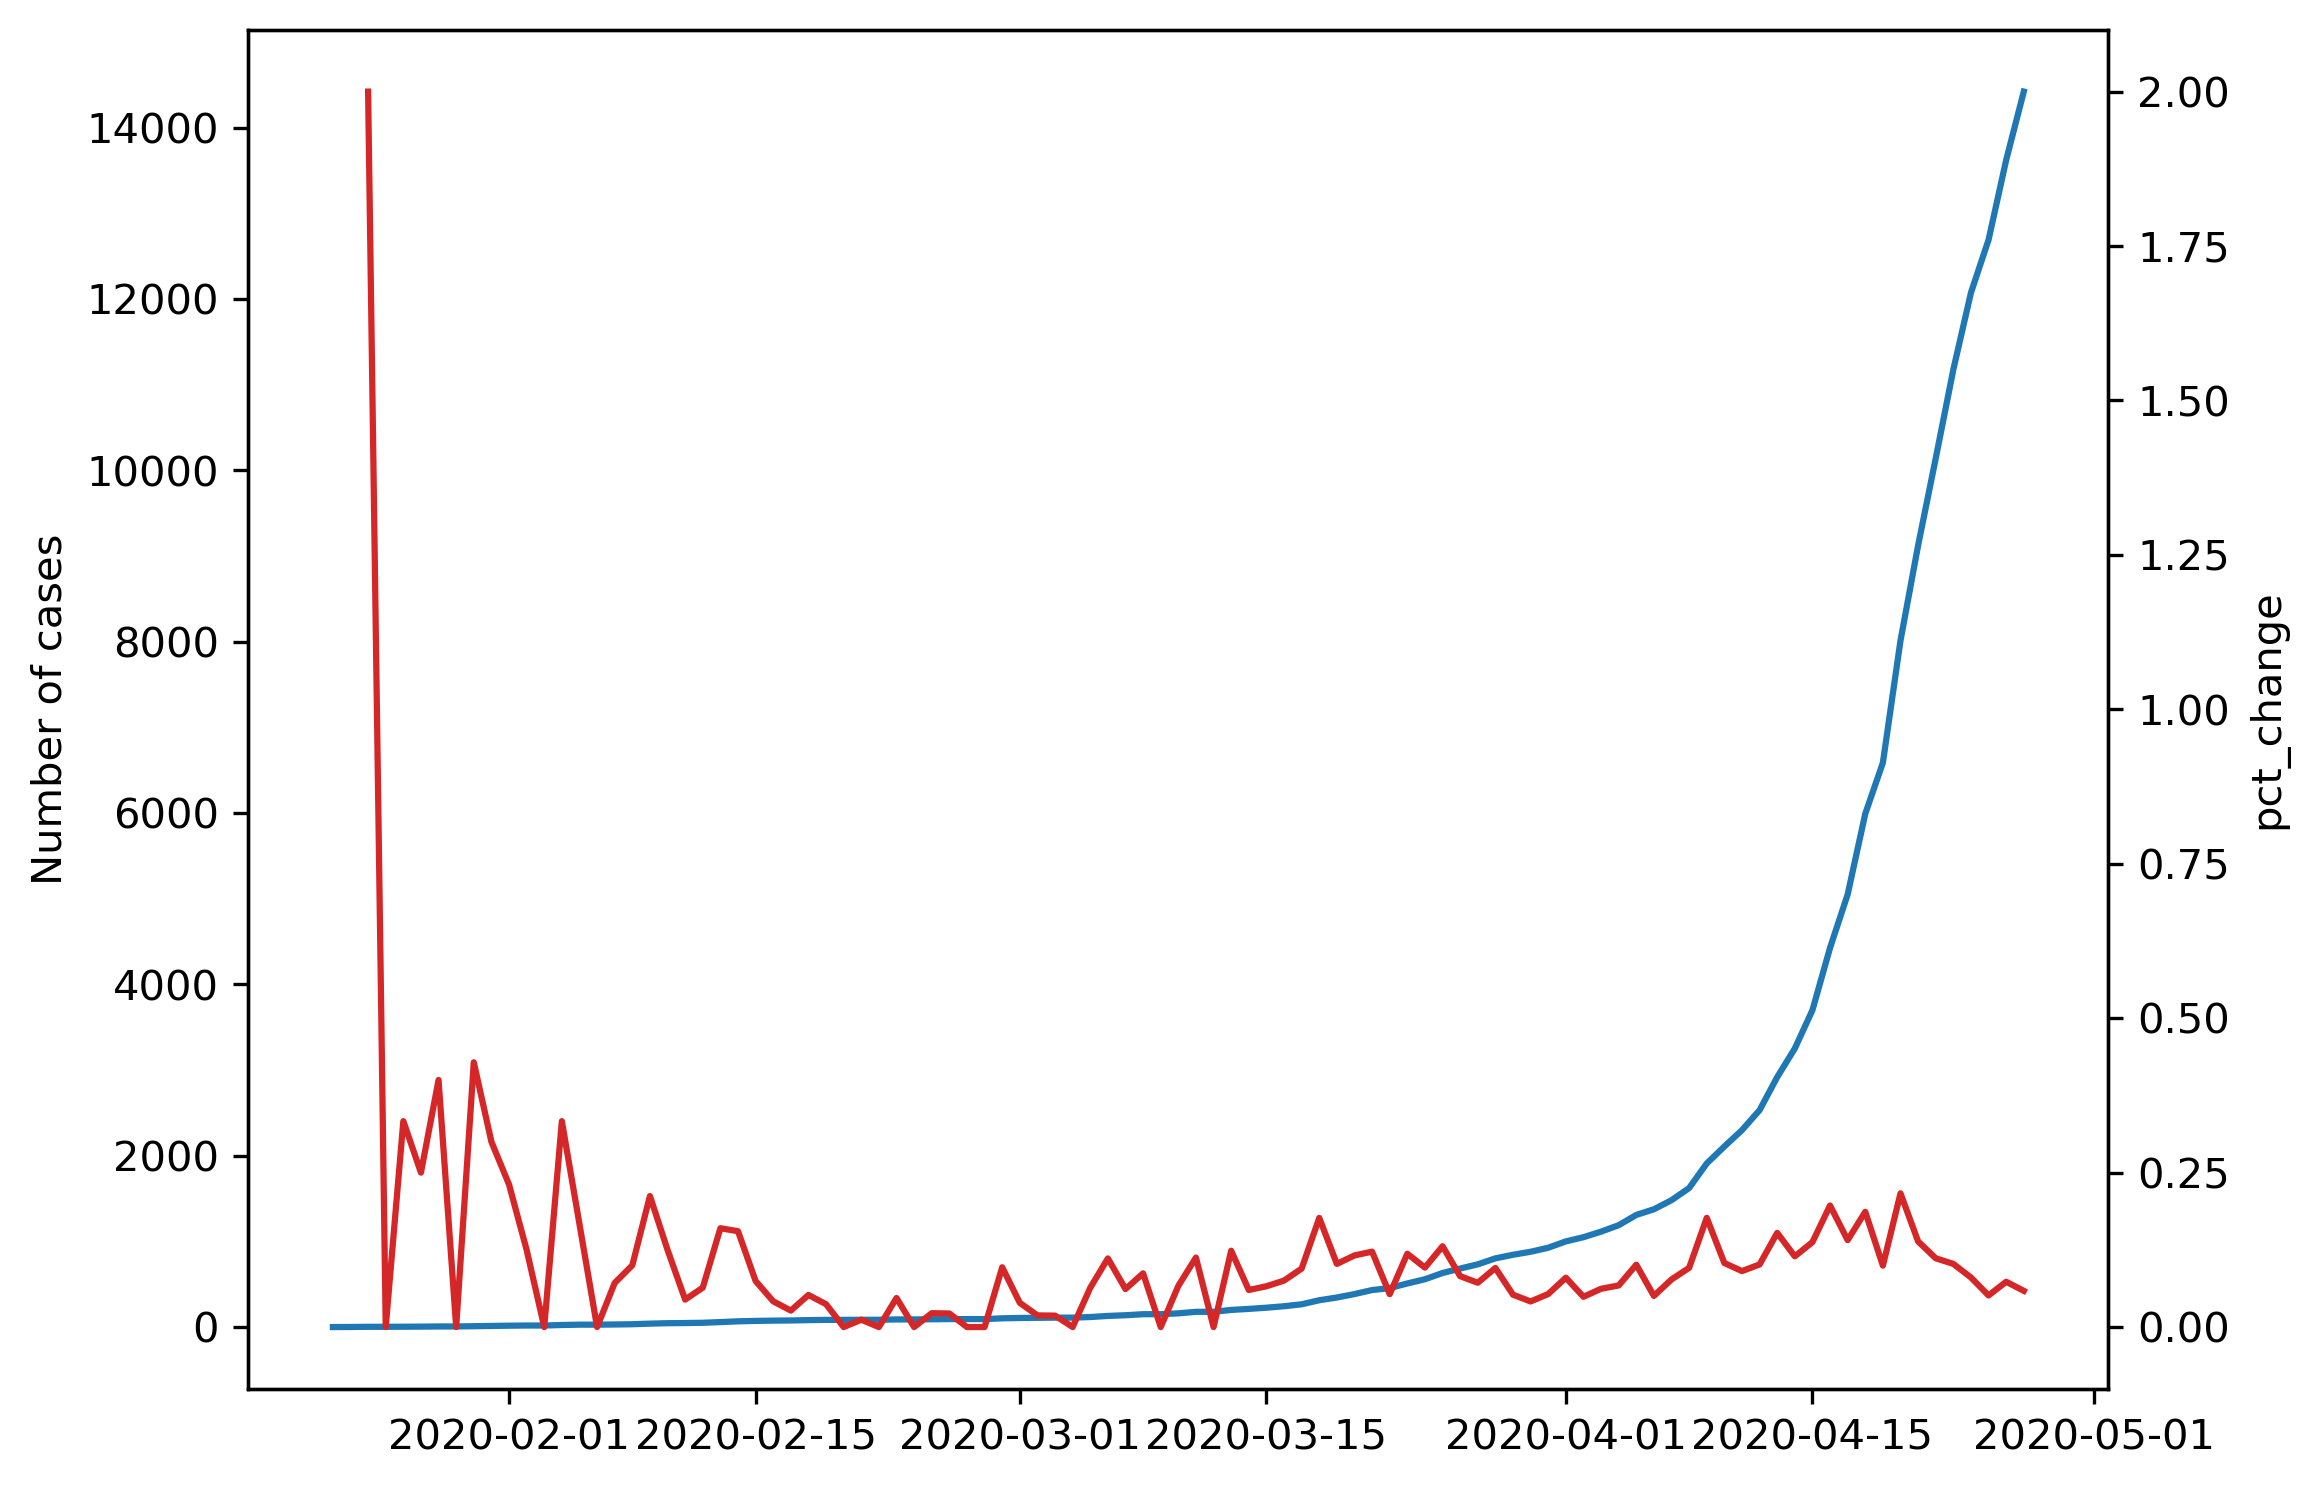

In [19]:
cases_and_rate(df_by_country['Singapore'])

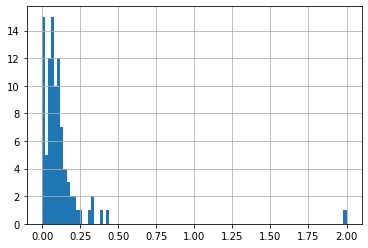

In [20]:
(df_by_country['Singapore'].pct_change()
 .dropna()
 .replace([np.inf, -np.inf], np.nan)
 .hist(bins=100)
)

## Germany

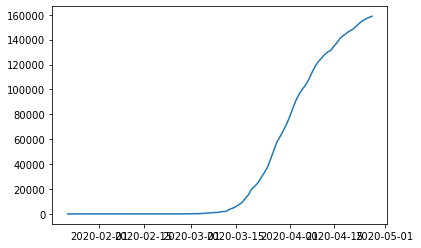

In [21]:
df_by_country['Germany'].plot()

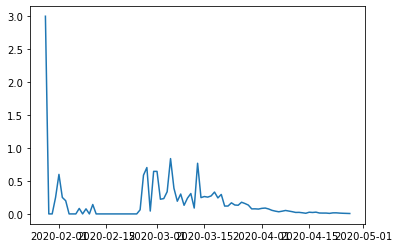

In [22]:
df_by_country['Germany'].pct_change().plot()

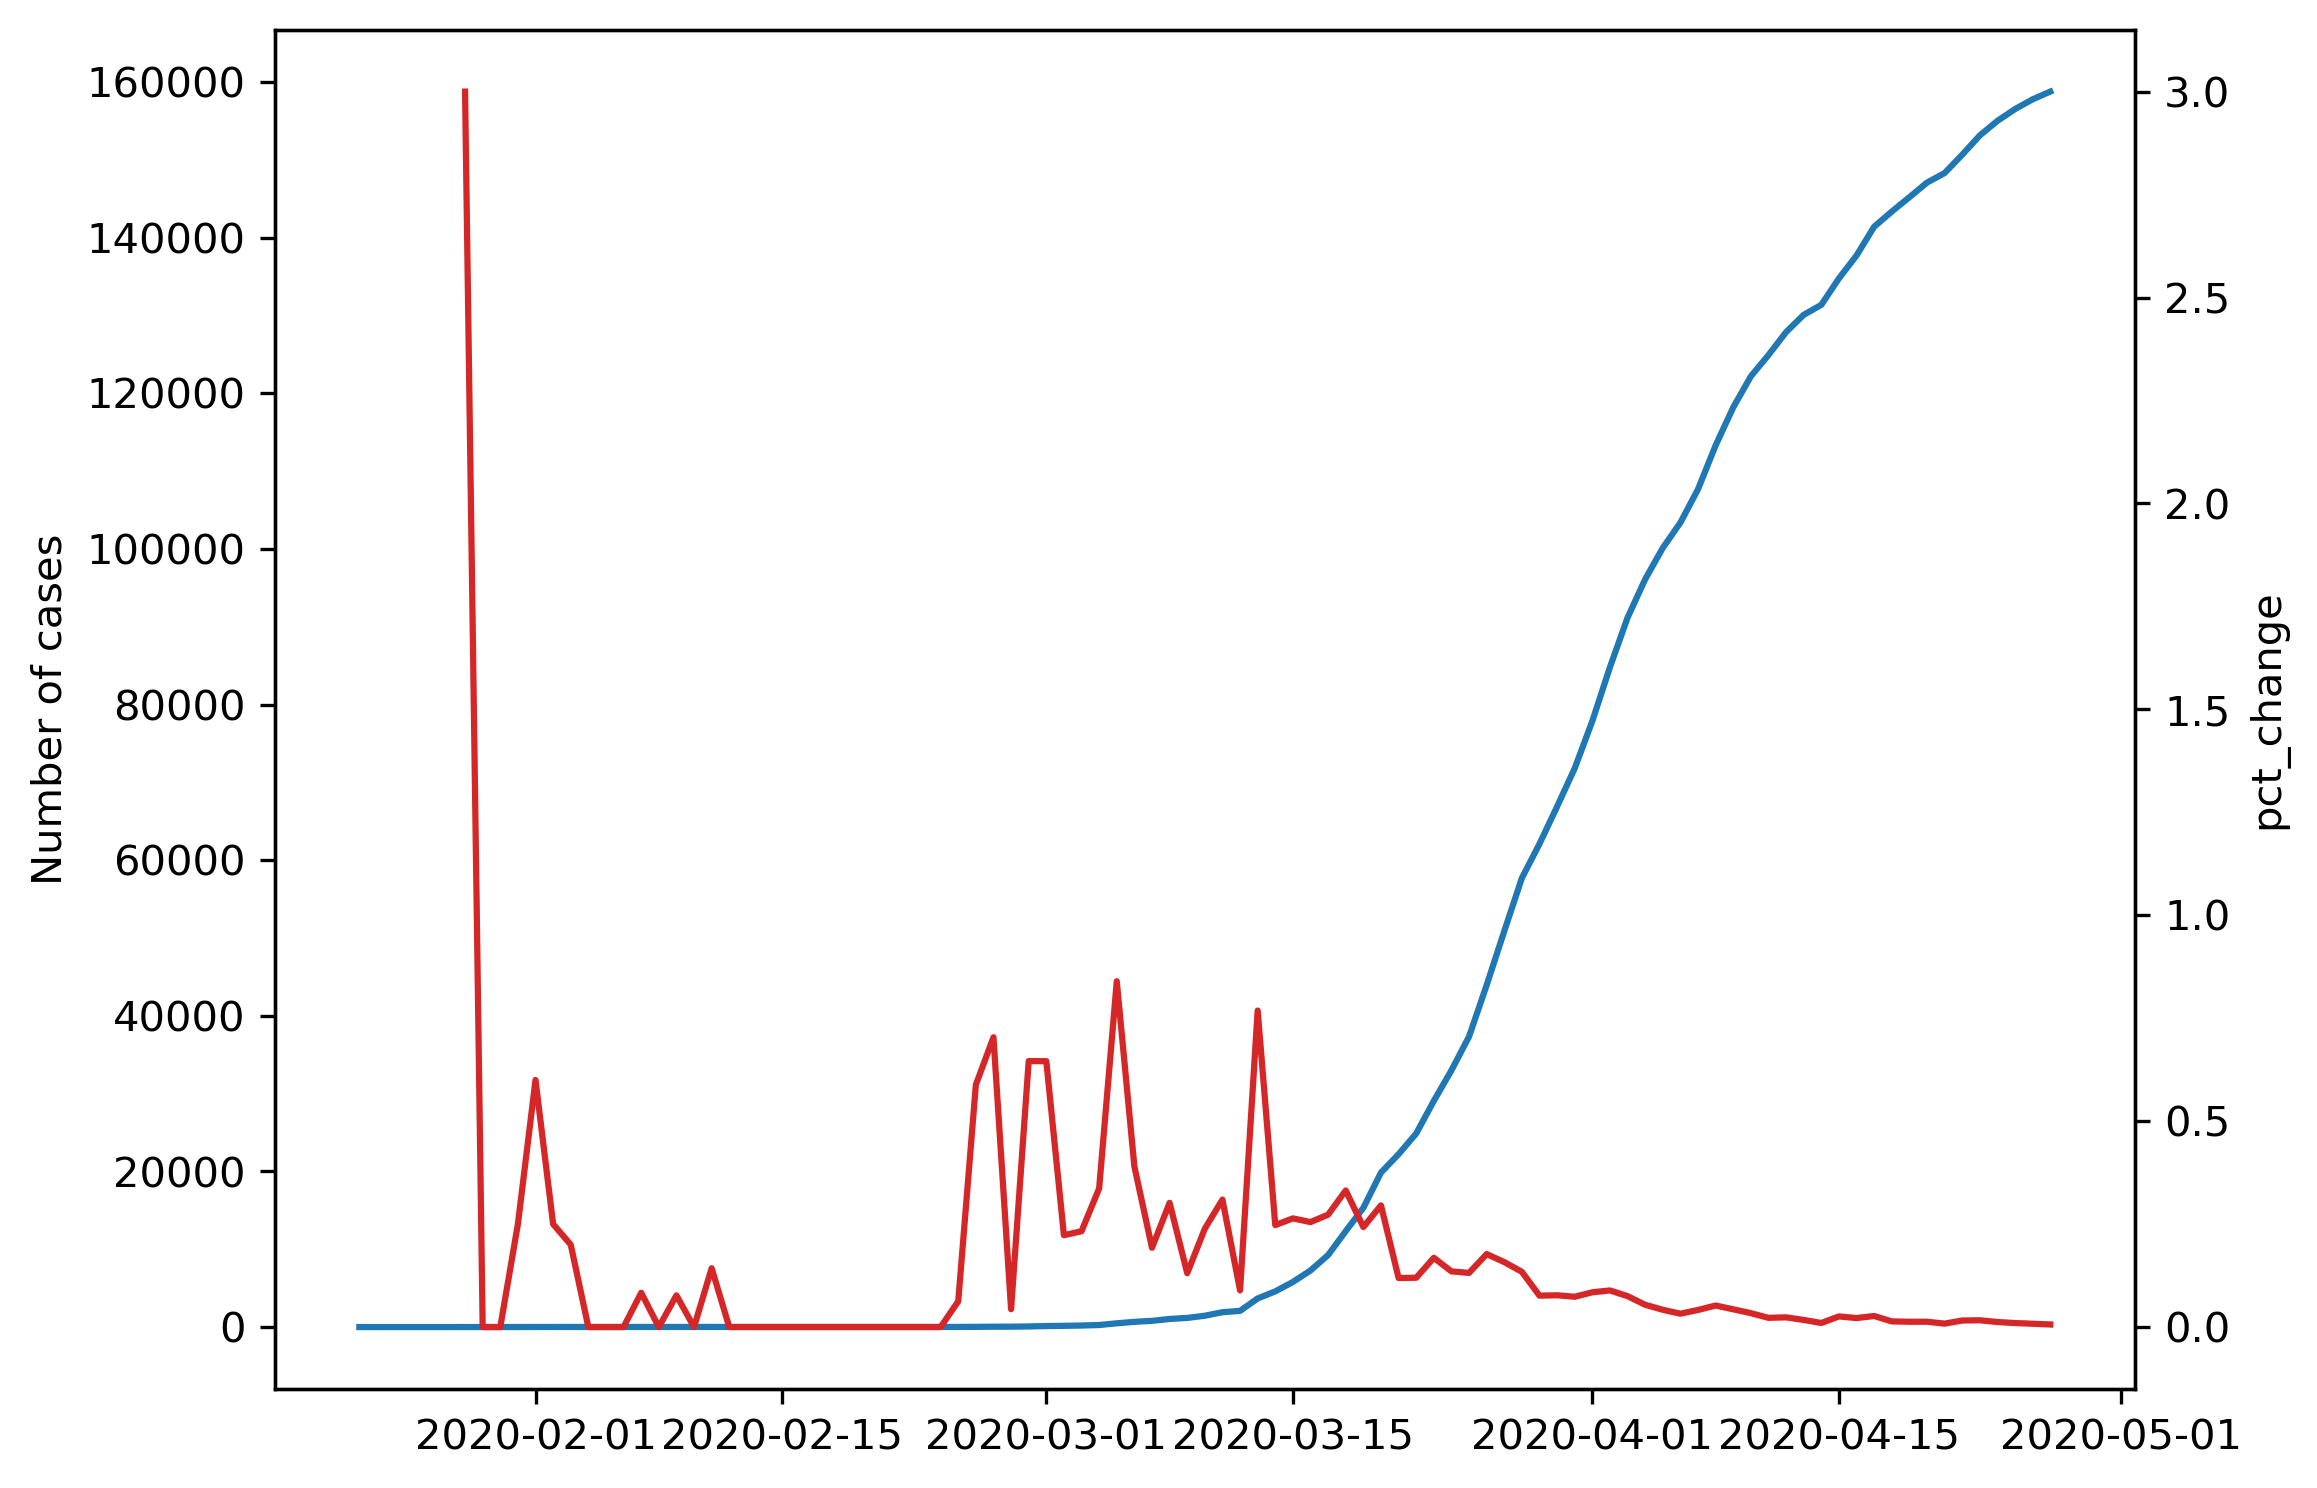

In [23]:
cases_and_rate(df_by_country['Germany'])

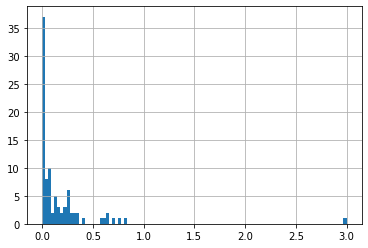

In [24]:
(df_by_country['Germany'].pct_change()
 .dropna()
 .replace([np.inf, -np.inf], np.nan)
 .hist(bins=100)
)

## United States

In [25]:
df_by_country.columns

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria',
       ...
       'United Kingdom', 'Uruguay', 'Uzbekistan', 'Venezuela', 'Vietnam',
       'West Bank and Gaza', 'Western Sahara', 'Yemen', 'Zambia', 'Zimbabwe'],
      dtype='object', name='Country/Region', length=185)

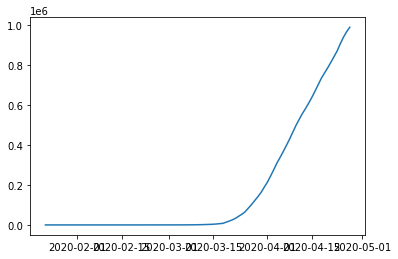

In [26]:
df_by_country['US'].plot()

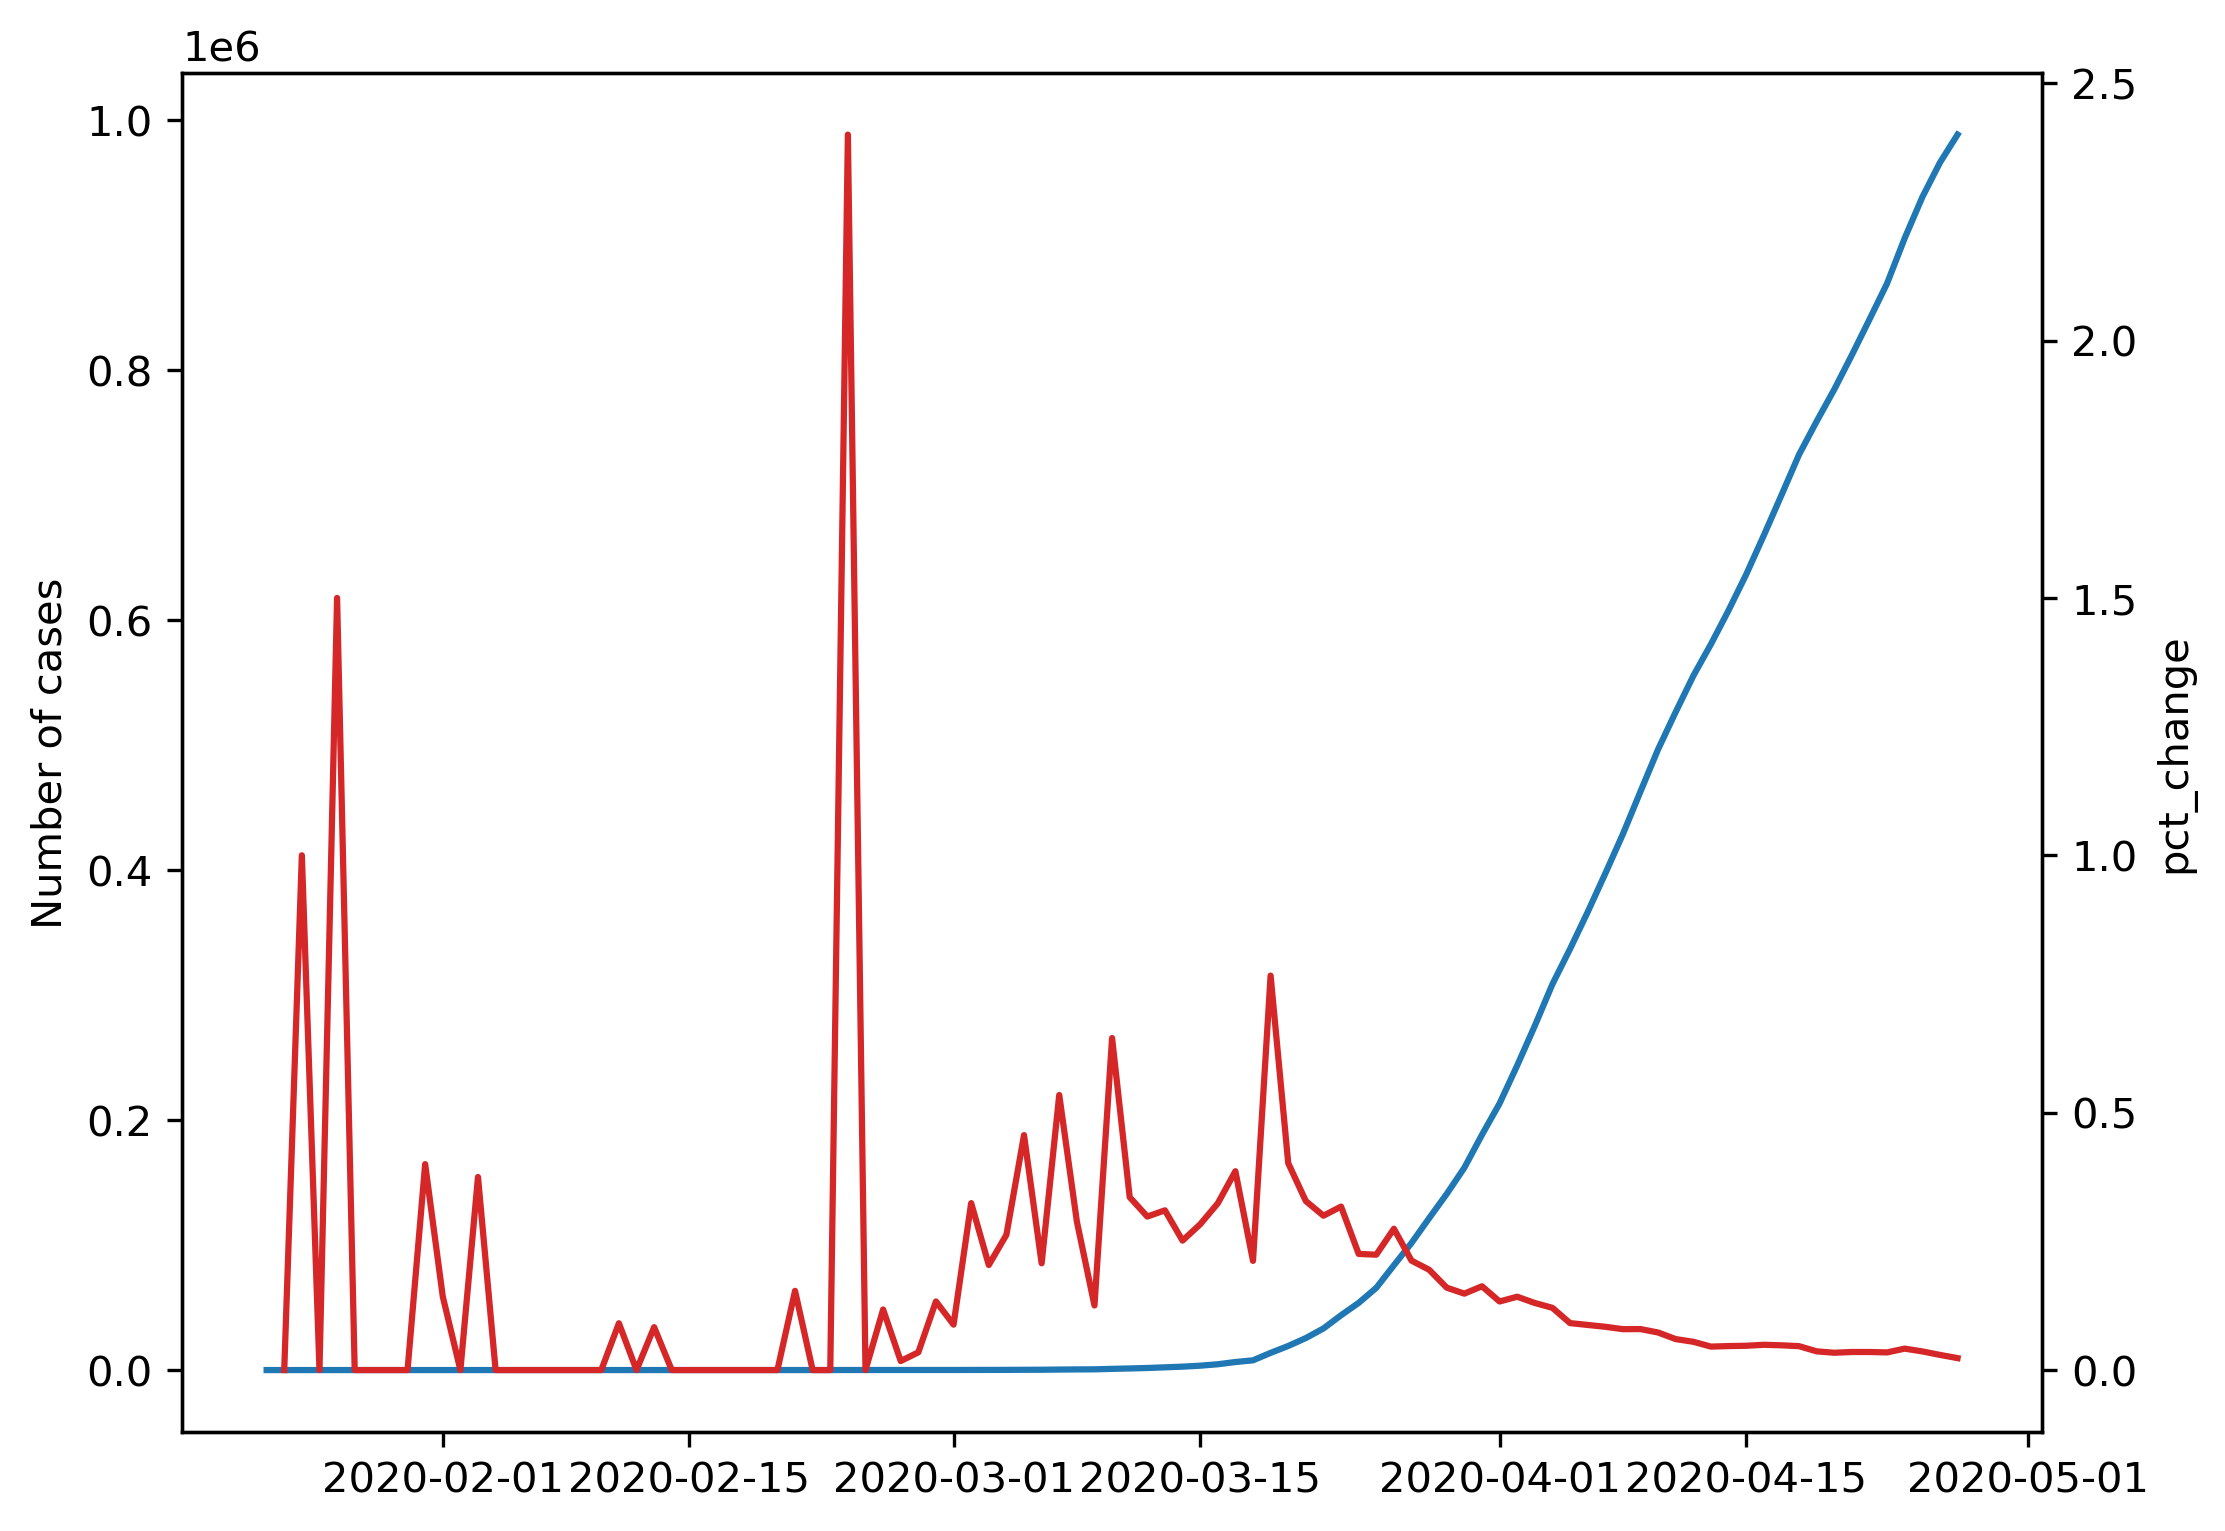

In [27]:
cases_and_rate(df_by_country['US'])

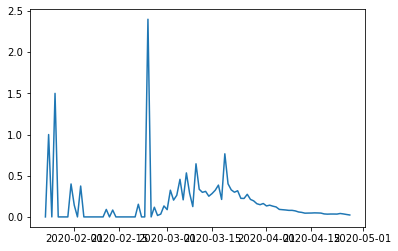

In [28]:
df_by_country['US'].pct_change().plot()

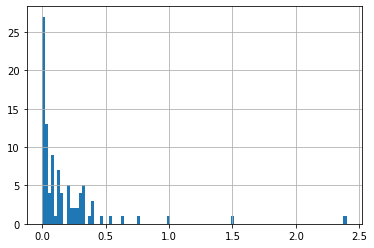

In [29]:
df_by_country['US'].pct_change().hist(bins=100)

## Italy

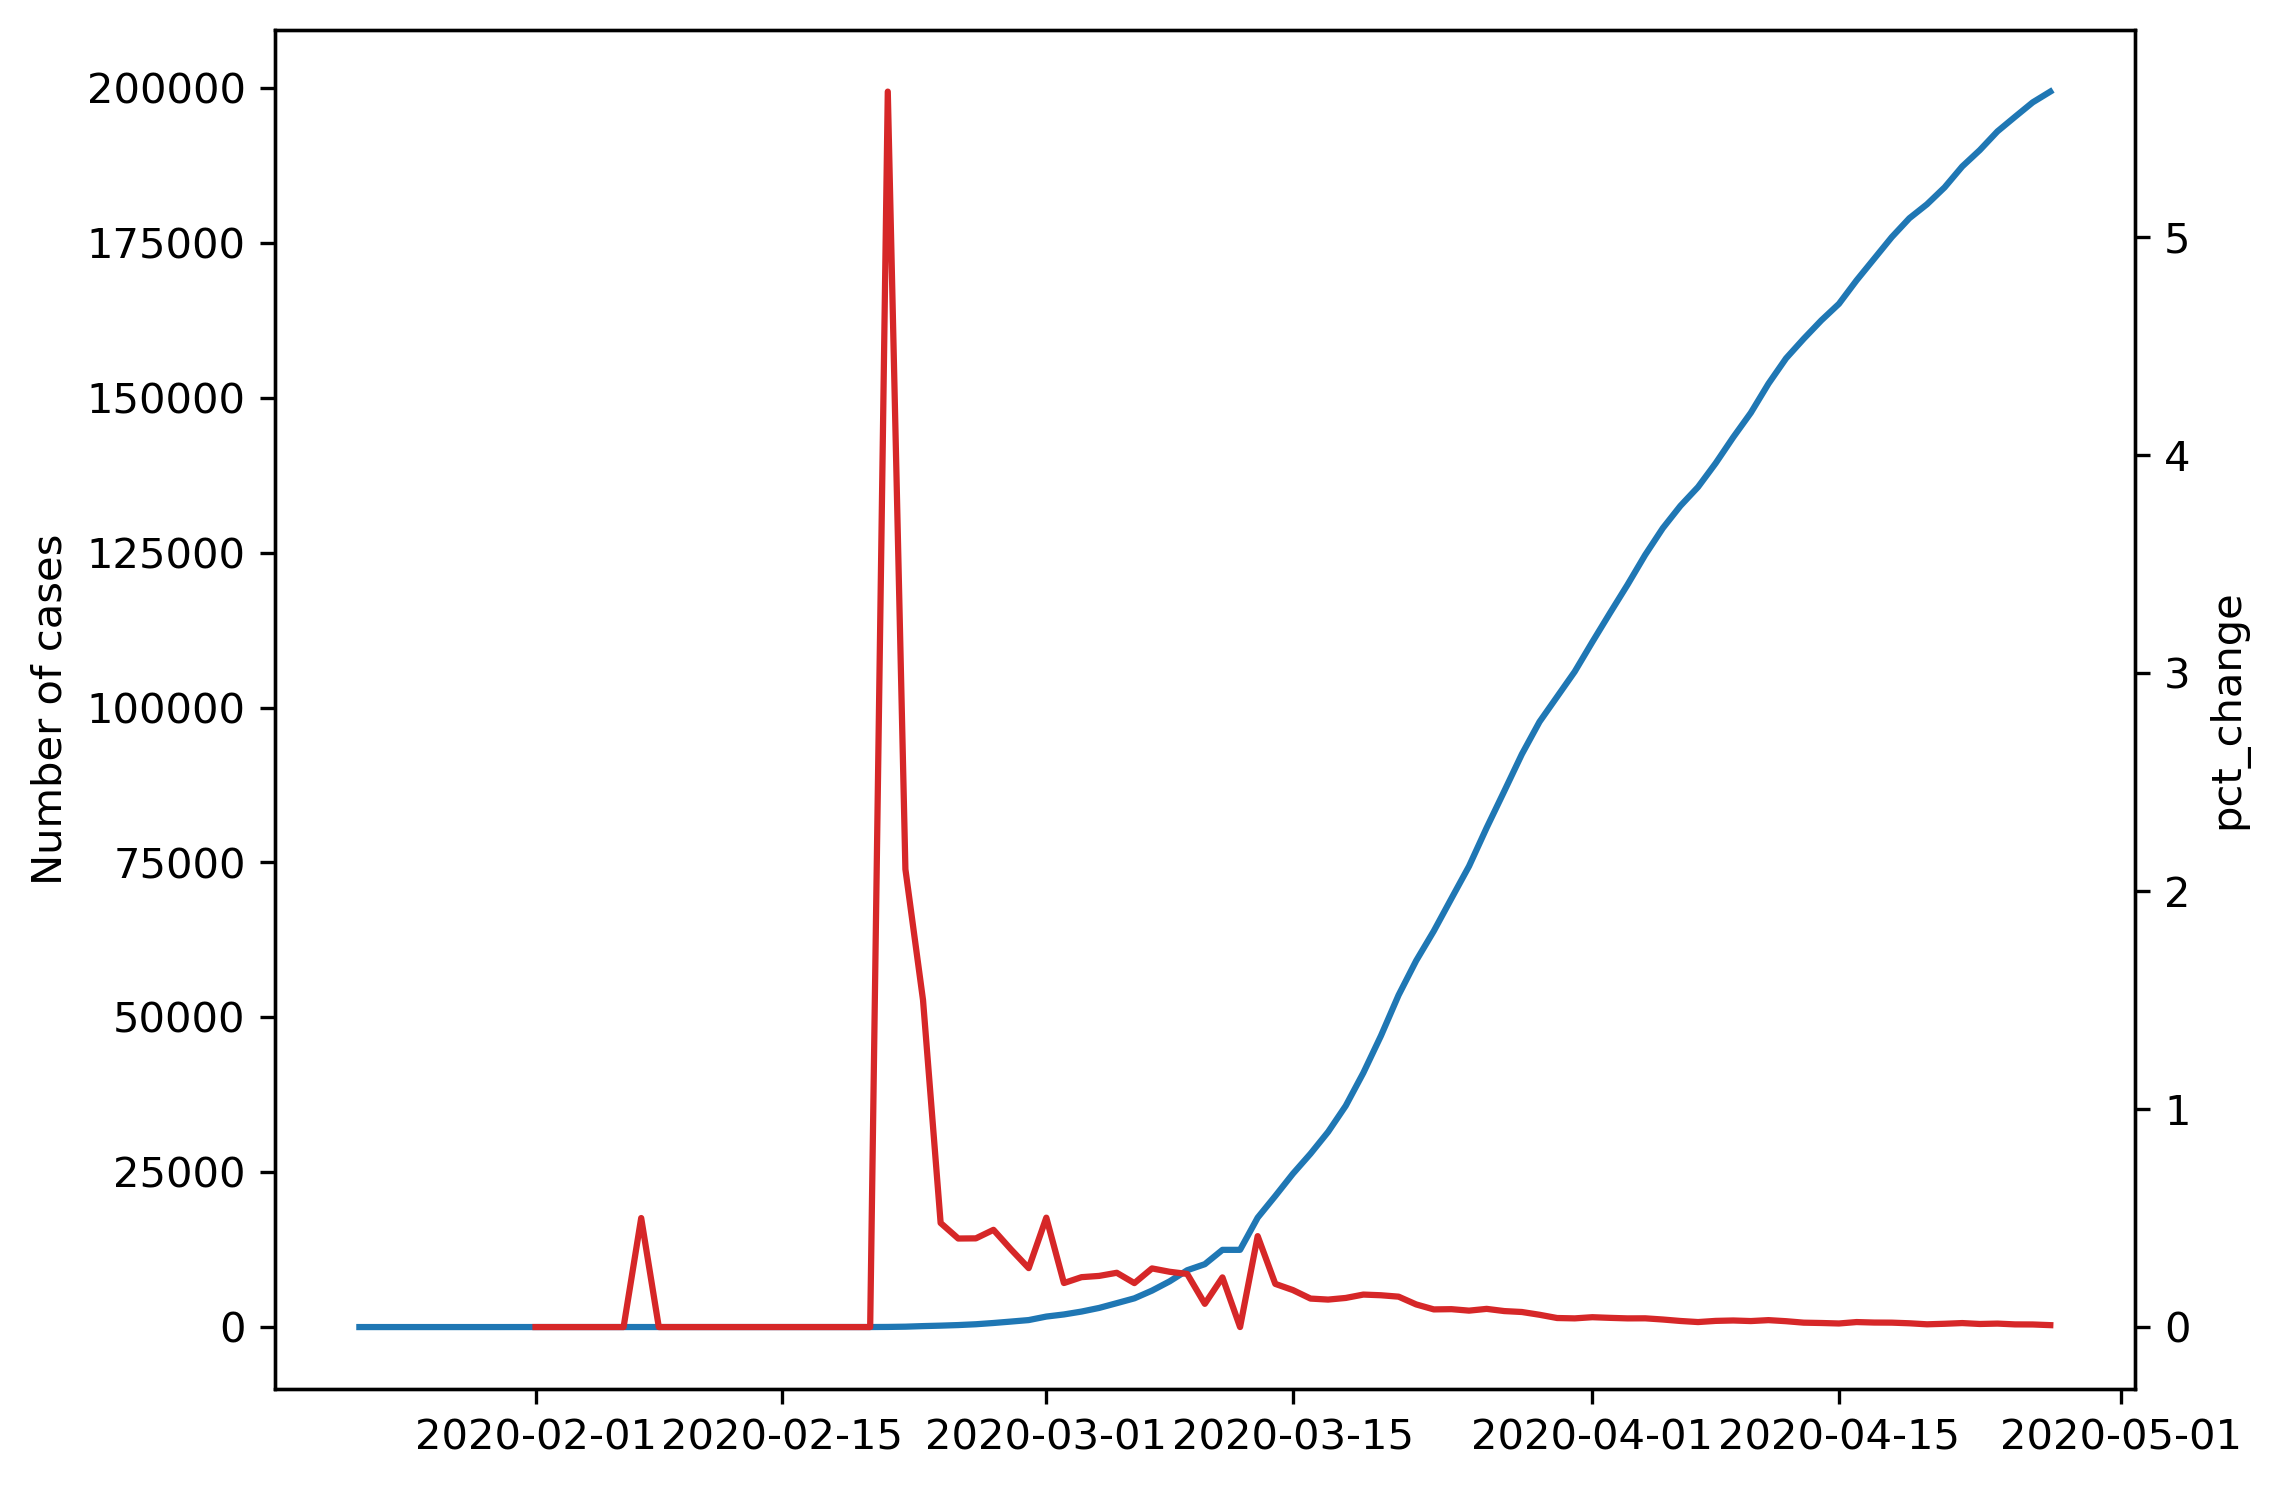

In [30]:
cases_and_rate(df_by_country['Italy'])

## Sweden
Of interest as a country that has not imposed any lockdown measures.

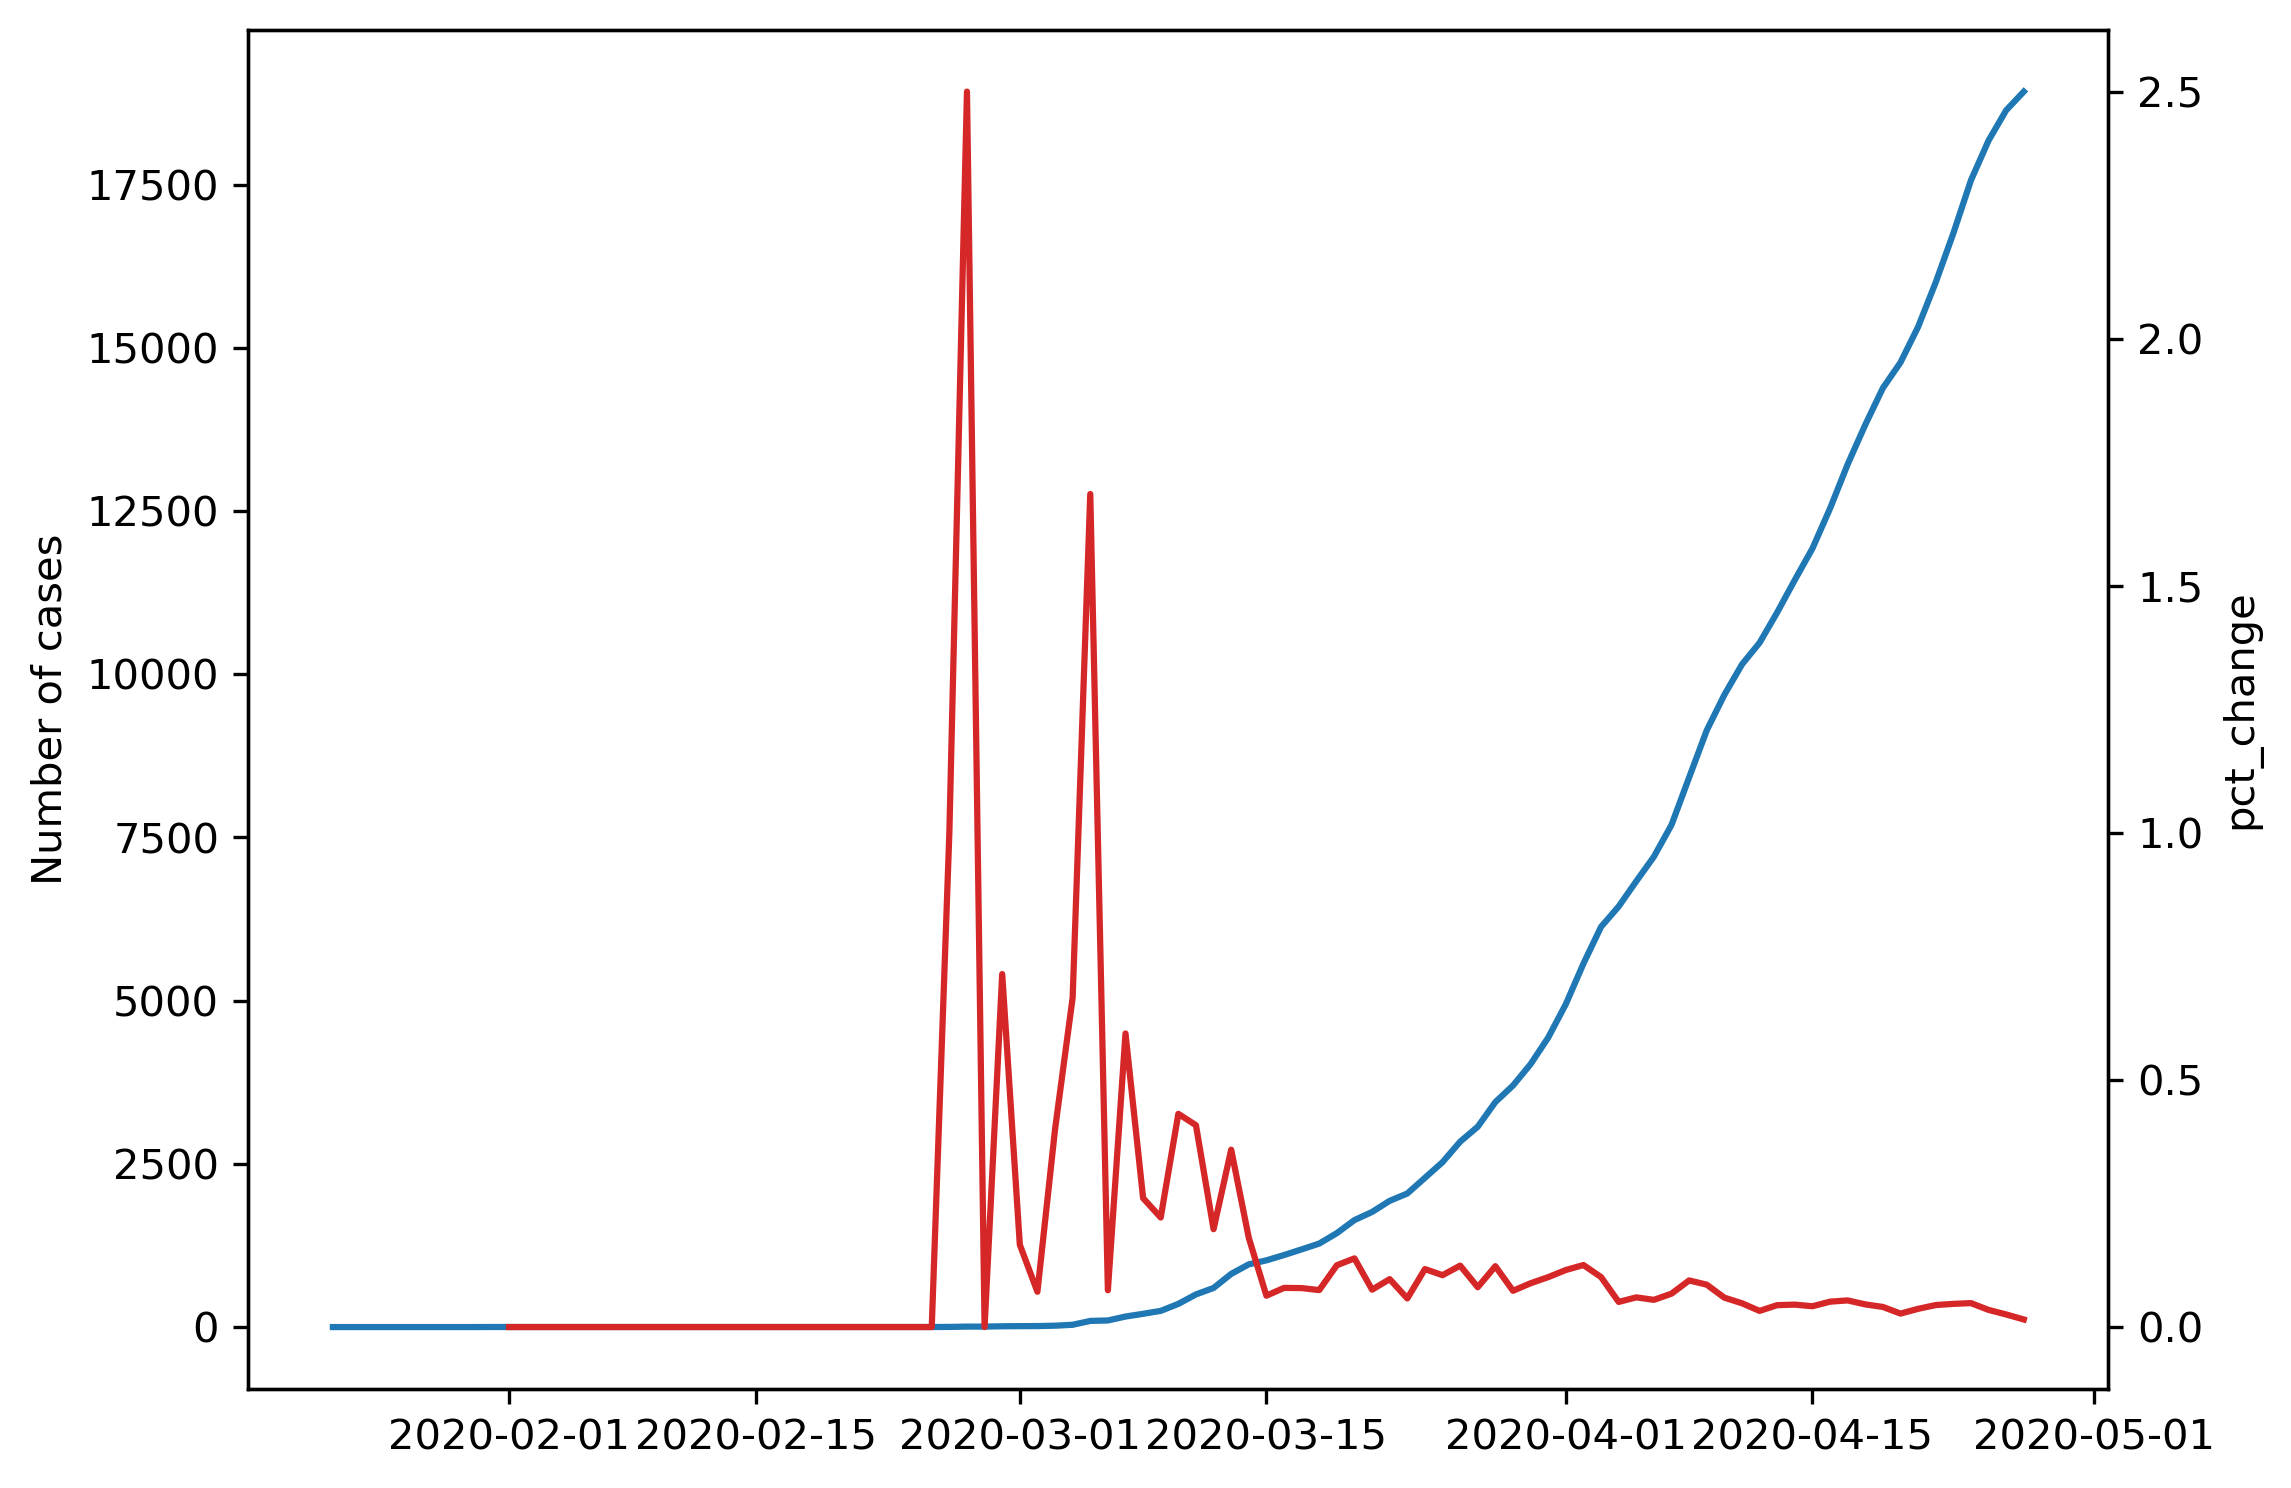

In [31]:
cases_and_rate(df_by_country['Sweden'])

## New Zealand

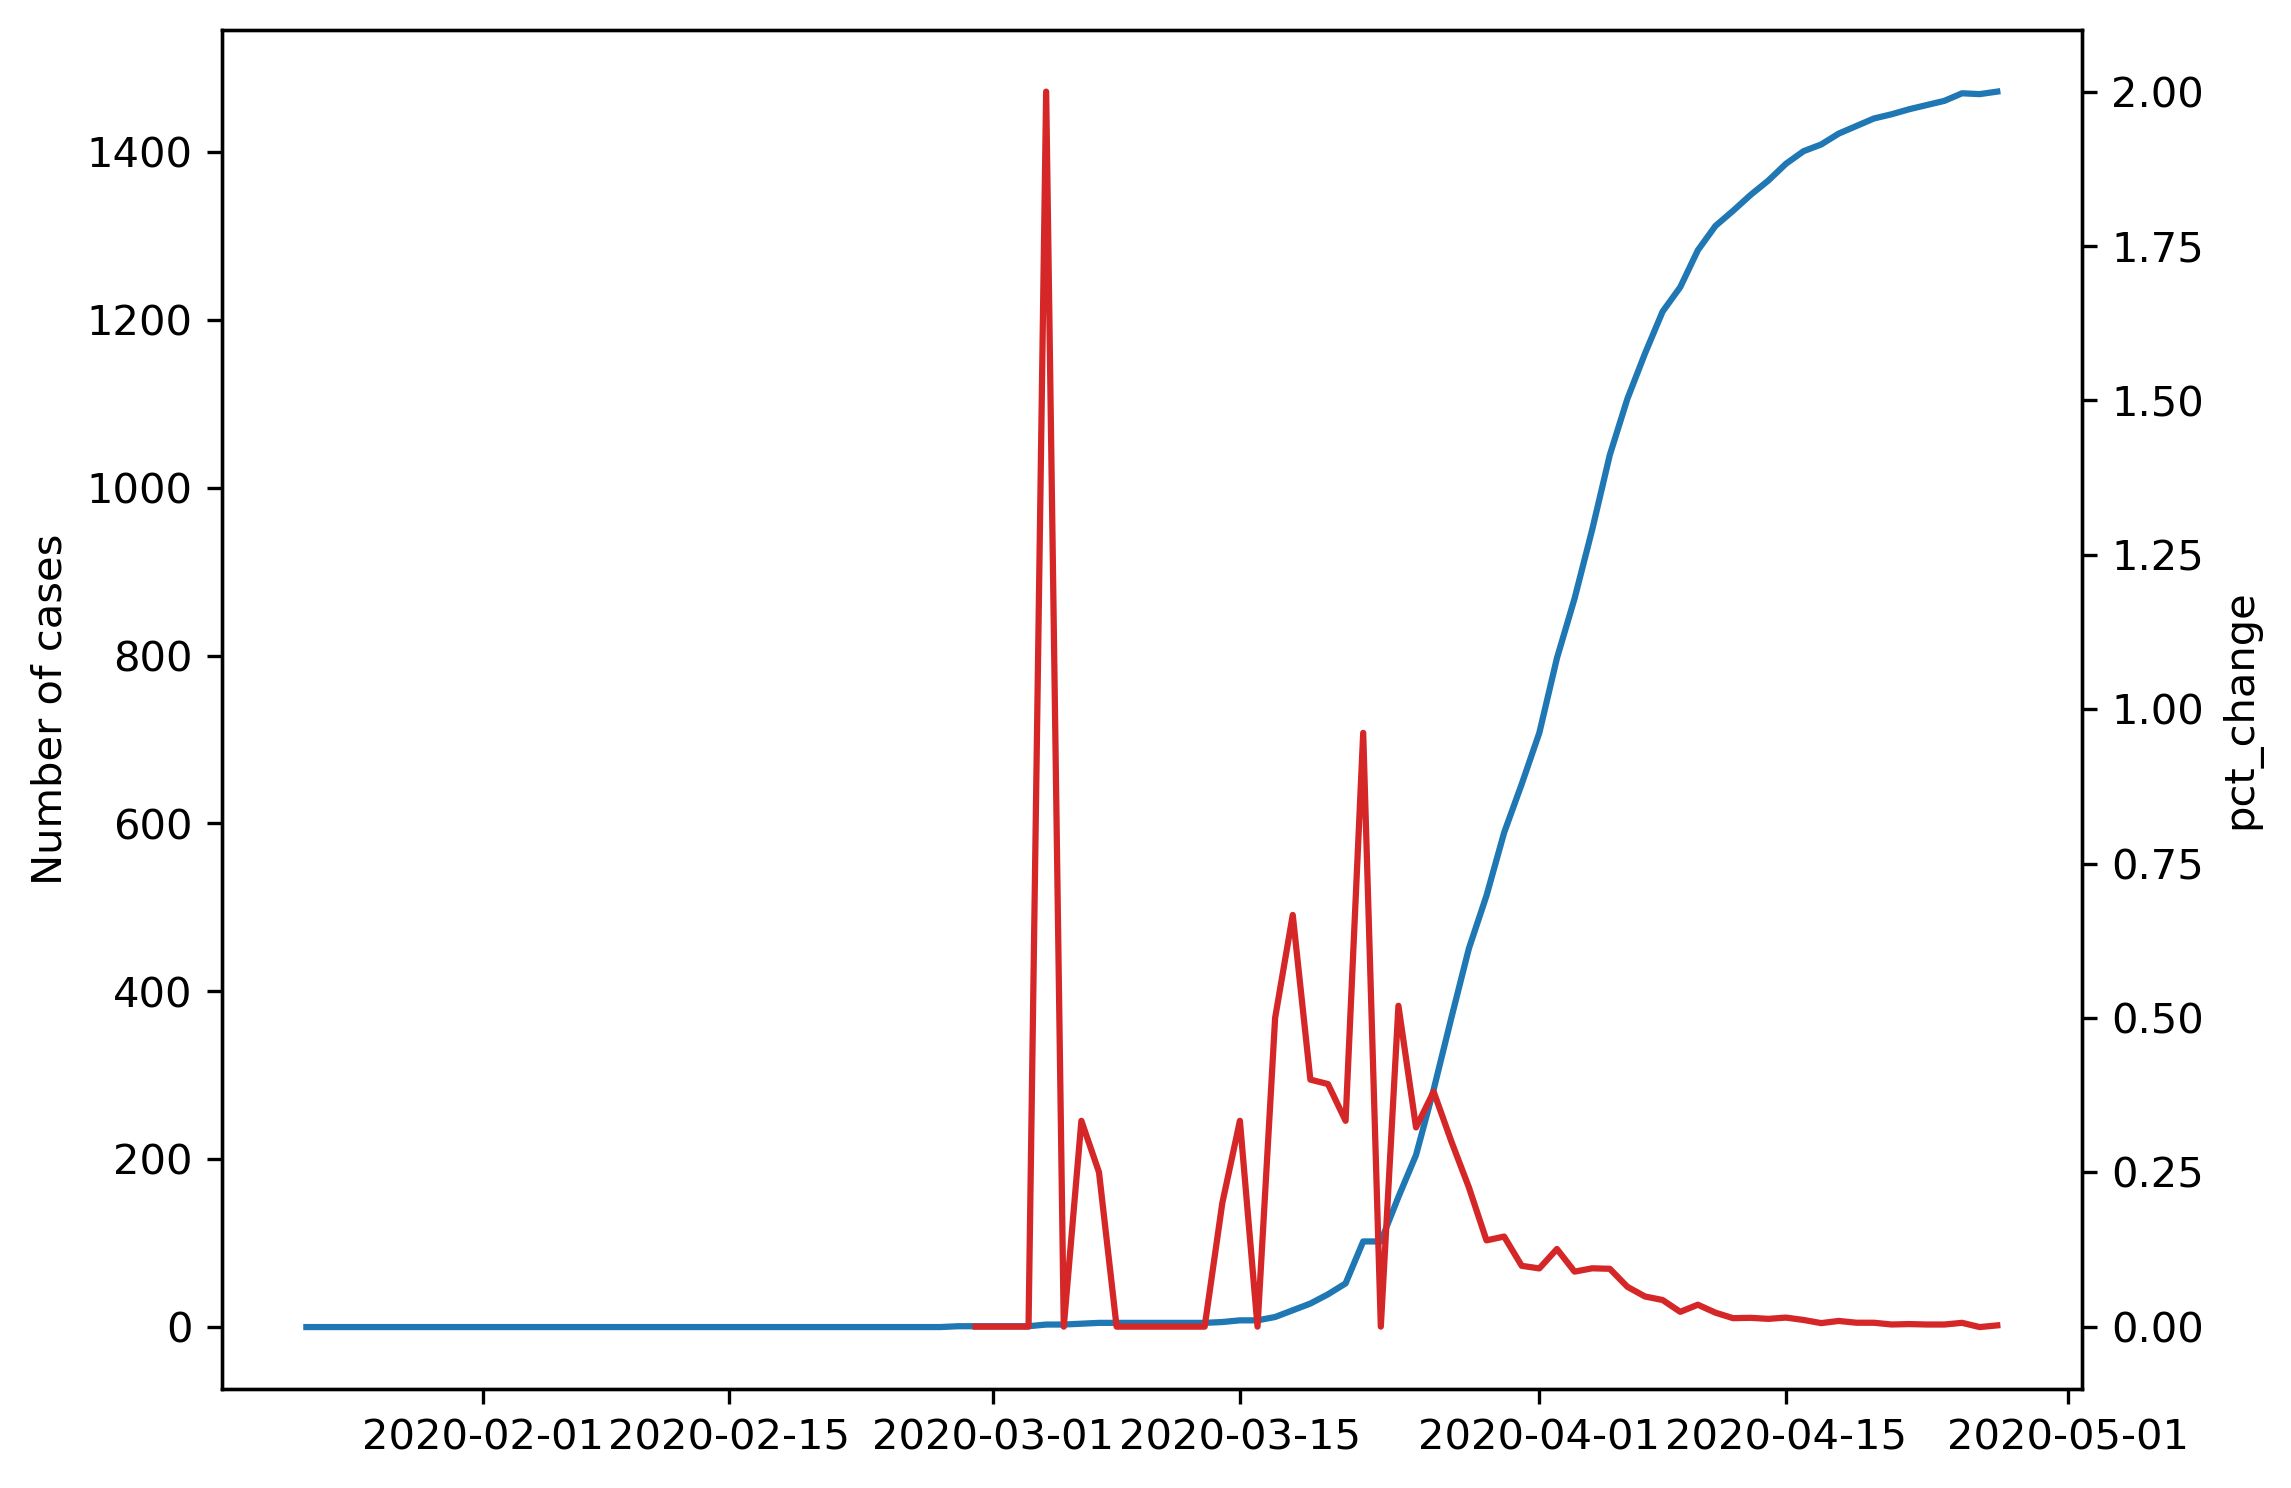

In [32]:
cases_and_rate(df_by_country['New Zealand'])

## Exploring change rates

### Checking where a appropriate cutoff for visualising change rates is

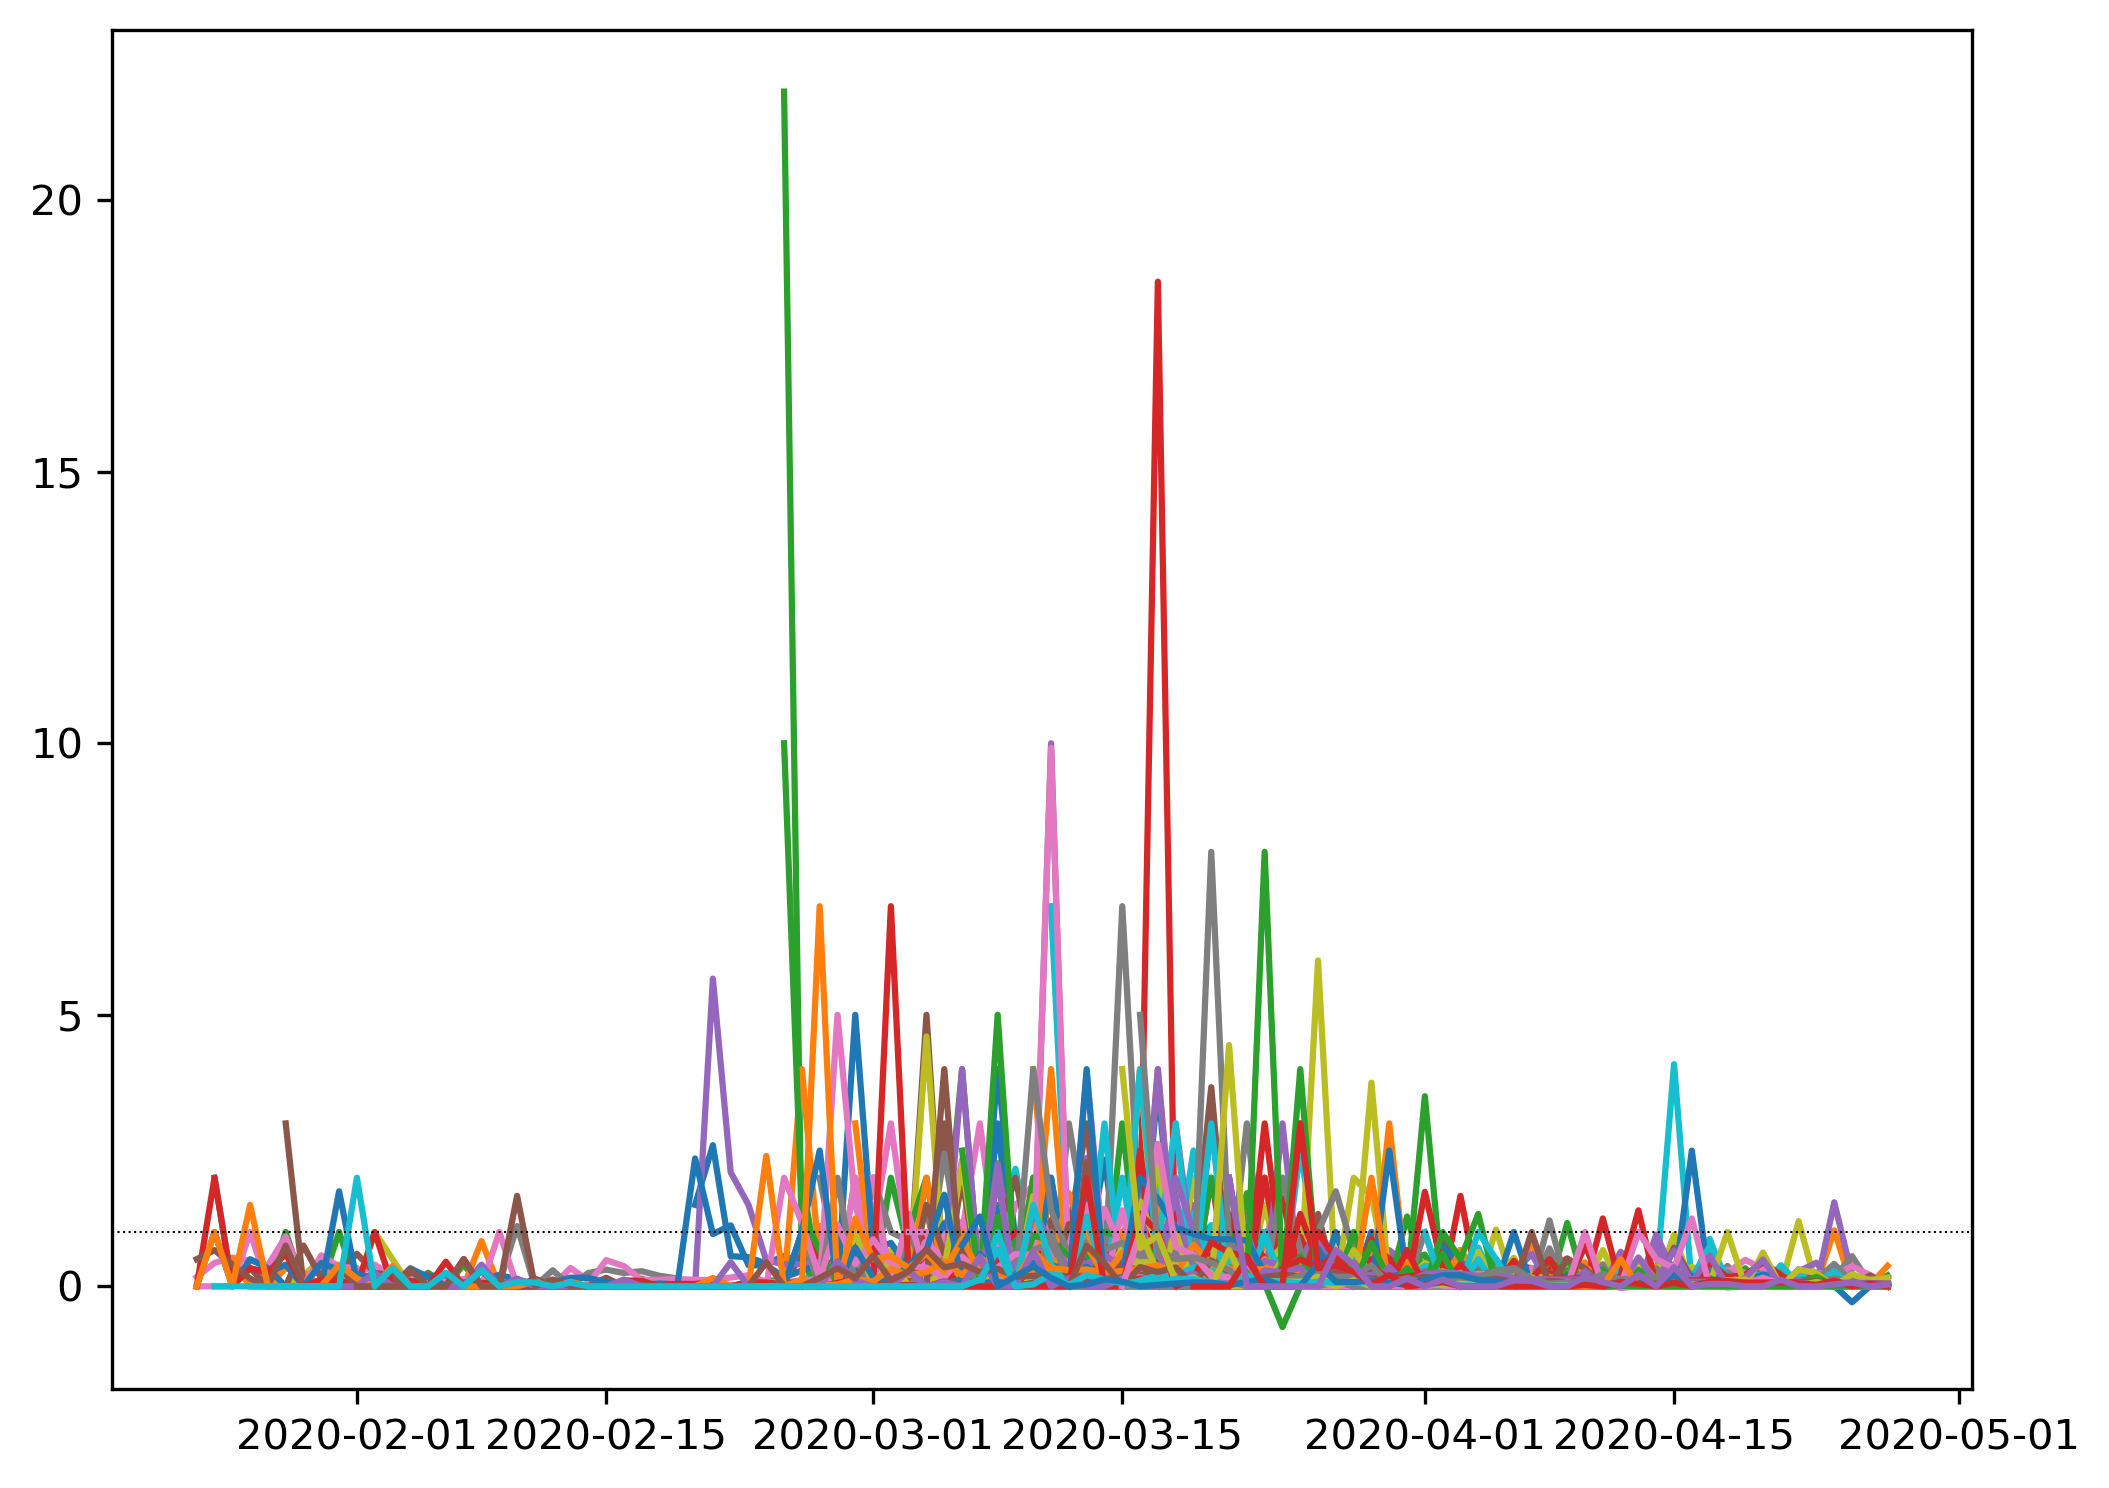

In [33]:
pct_fig, pct_ax = plt.subplots(figsize=(8,6), dpi=300)
pct_ax.plot(df_by_country.pct_change())
pct_ax.axhline(y=1, color="black", linestyle=":", linewidth=".5")

The key observation from the above graph is that percentage changes above 100% are usually an artifact of low case numbers, and cases before this time (at least) should be filtered out.

In [34]:
df_by_country.pct_change() > 1

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
2020-01-22,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-01-23,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2020-01-24,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-01-25,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-01-26,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-23,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-04-24,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-04-25,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-04-26,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [35]:
df_by_country[df_by_country.pct_change() > 1]

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_by_country['Sweden'][df_by_country['Sweden'].pct_change() > 1].index[-1]

datetime.date(2020, 3, 5)

In [37]:
def get_last_date_crossed(series, threshold):
    try:
        result = series[series.pct_change() > threshold].index[-1]
        return result
    except IndexError:
        return np.nan

In [38]:
def get_last_date_crossed_1(series):
    return get_last_date_crossed(series, 1)

In [39]:
dates_last_crossed_1 = df_by_country.apply(func=get_last_date_crossed_1).dropna()
dates_last_crossed_1

Country/Region
Afghanistan           2020-03-08
Albania               2020-03-10
Algeria               2020-03-04
Andorra               2020-03-17
Angola                2020-03-20
                         ...    
West Bank and Gaza    2020-03-07
Western Sahara        2020-04-05
Yemen                 2020-04-10
Zambia                2020-03-25
Zimbabwe              2020-03-21
Length: 182, dtype: object

According to this result, as of currently run period, 3 countries ($185 - 182 = 3$) have not crossed 100% increase in cases yet.

Next, we take a look at which countries this may be.

In [40]:
set(df_by_country.columns) - set(dates_last_crossed_1.index)

{'China', 'Japan', 'Thailand'}

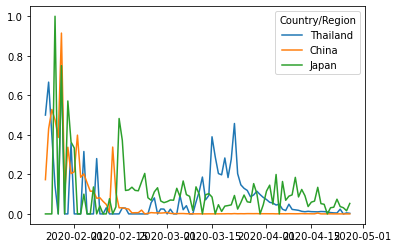

In [42]:
df_by_country[set(df_by_country.columns) - set(dates_last_crossed_1.index)].pct_change().plot()

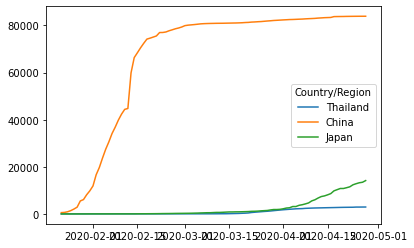

In [43]:
df_by_country[set(df_by_country.columns) - set(dates_last_crossed_1.index)].plot()

This suggests a problem with the function, since these three countries have had cases, but have never crossed 100% increases in case count throughout their history. This suggests that the threshold should be lowered.

In [44]:
df_by_country['Thailand'].pct_change().max()

0.75

In [45]:
def get_last_date_crossed_07499(series):
    return get_last_date_crossed(series, .7499)

In [46]:
dates_last_crossed_07499 = df_by_country.apply(func=get_last_date_crossed_07499).dropna()
dates_last_crossed_07499

Country/Region
Afghanistan           2020-03-24
Albania               2020-03-12
Algeria               2020-03-04
Andorra               2020-03-17
Angola                2020-03-21
                         ...    
West Bank and Gaza    2020-03-07
Western Sahara        2020-04-05
Yemen                 2020-04-10
Zambia                2020-03-25
Zimbabwe              2020-03-21
Length: 185, dtype: object

In [47]:
df_by_country['Afghanistan'][dt.date(2020, 3, 8)]

4

In [48]:
for i in dates_last_crossed_07499.index:
    print(f"Country: {i}, Date: {dates_last_crossed_07499[i]}, Case Count: {df_by_country[i][dates_last_crossed_07499[i]]}")

Country: Afghanistan, Date: 2020-03-24, Case Count: 74
Country: Albania, Date: 2020-03-12, Case Count: 23
Country: Algeria, Date: 2020-03-04, Case Count: 12
Country: Andorra, Date: 2020-03-17, Case Count: 39
Country: Angola, Date: 2020-03-21, Case Count: 2
Country: Antigua and Barbuda, Date: 2020-03-26, Case Count: 7
Country: Argentina, Date: 2020-03-07, Case Count: 8
Country: Armenia, Date: 2020-03-16, Case Count: 52
Country: Australia, Date: 2020-01-26, Case Count: 4
Country: Austria, Date: 2020-02-29, Case Count: 9
Country: Azerbaijan, Date: 2020-03-05, Case Count: 6
Country: Bahamas, Date: 2020-03-26, Case Count: 9
Country: Bahrain, Date: 2020-03-11, Case Count: 195
Country: Bangladesh, Date: 2020-03-08, Case Count: 3
Country: Barbados, Date: 2020-03-22, Case Count: 14
Country: Belarus, Date: 2020-04-02, Case Count: 304
Country: Belgium, Date: 2020-03-13, Case Count: 559
Country: Belize, Date: 2020-03-25, Case Count: 2
Country: Benin, Date: 2020-03-23, Case Count: 5
Country: Bhutan

In [49]:
last_crossed_07499 = dates_last_crossed_07499.to_frame(name='Date')
last_crossed_07499['Case Count'] = [df_by_country[x][dates_last_crossed_07499[x]] for x in dates_last_crossed_07499.index]
last_crossed_07499

,Date,Case Count
Country/Region,,
Afghanistan,2020-03-24,74
Albania,2020-03-12,23
Algeria,2020-03-04,12
Andorra,2020-03-17,39
Angola,2020-03-21,2
...,...,...
West Bank and Gaza,2020-03-07,16
Western Sahara,2020-04-05,4
Yemen,2020-04-10,1


In [50]:
last_crossed_07499.describe()

,Case Count
count,185.000000
mean,349.794595
std,2037.212357
min,1.000000
25%,7.000000
50%,16.000000
75%,66.000000
max,22719.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f694795df10>]],
      dtype=object)

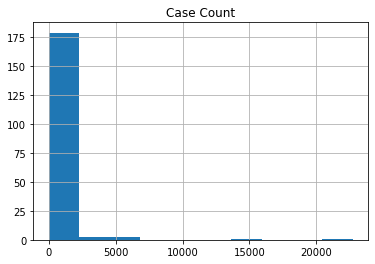

In [51]:
last_crossed_07499.hist()

In [52]:
last_crossed_07499.sort_values(by='Case Count')

,Date,Case Count
Country/Region,,
Yemen,2020-04-10,1
Fiji,2020-03-22,2
Angola,2020-03-21,2
Bosnia and Herzegovina,2020-03-05,2
Seychelles,2020-03-14,2
...,...,...
Germany,2020-03-13,3675
Spain,2020-03-13,5232
China,2020-01-28,5509


Ecuador has an alarmingly high case count for the most recent 100% change day.

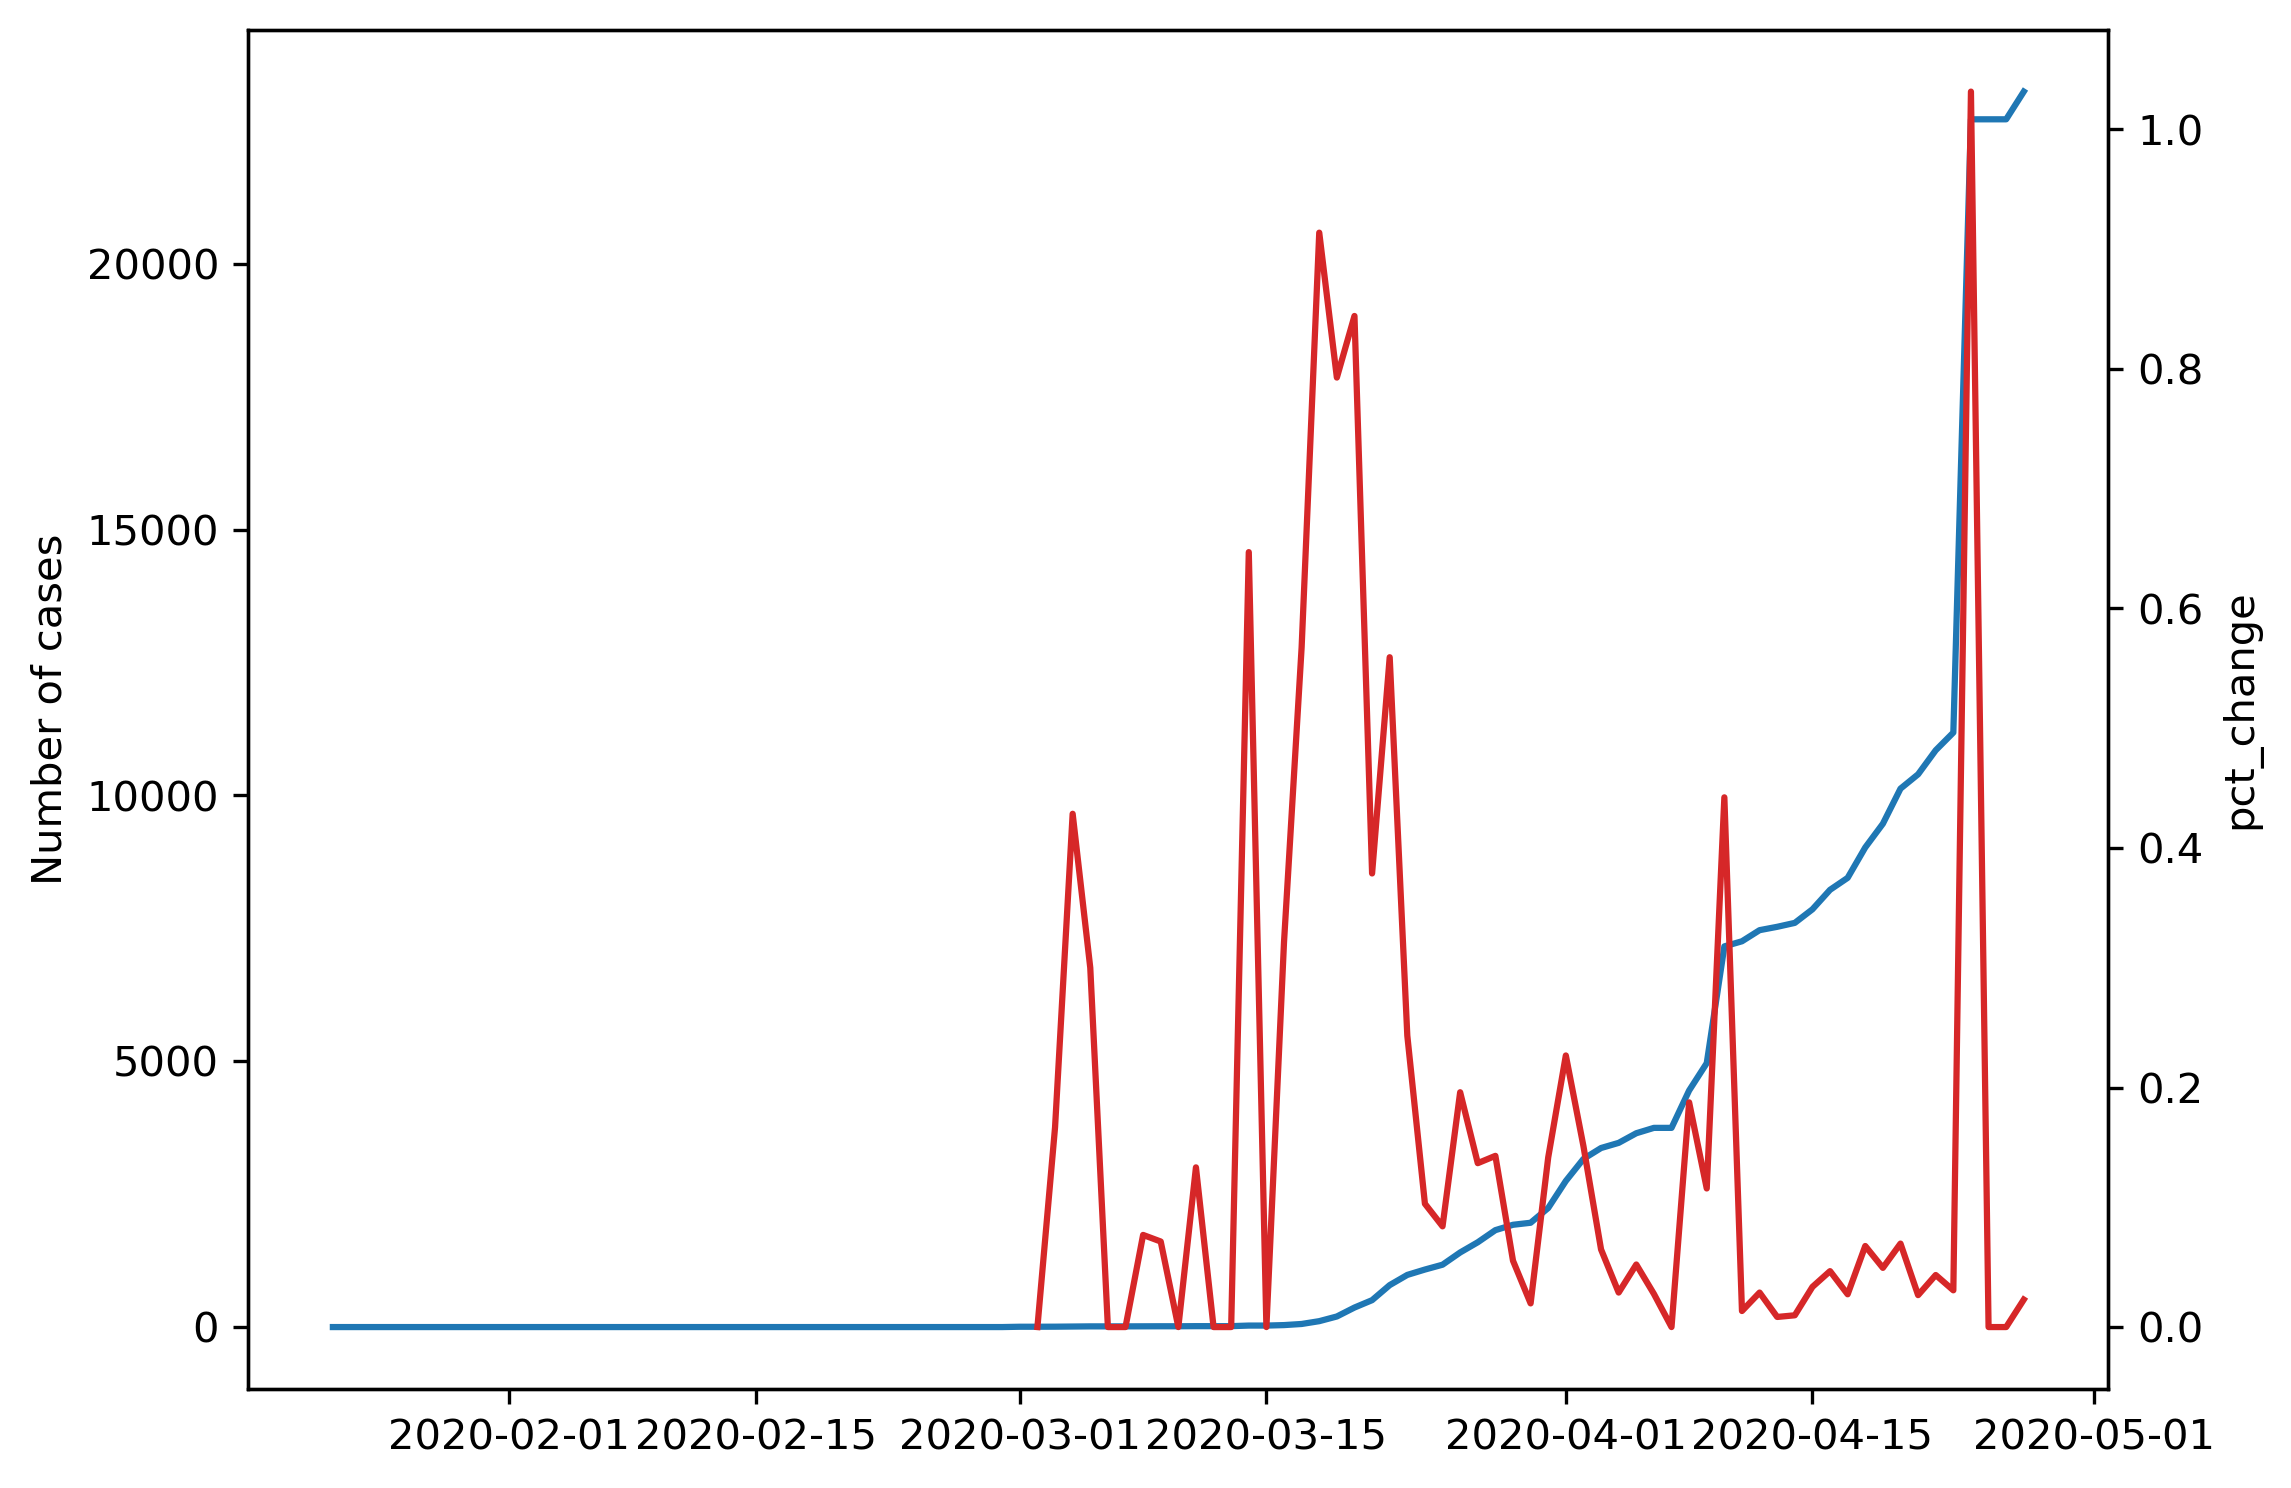

In [53]:
cases_and_rate(df_by_country['Ecuador'])

In [54]:
df_by_country['Ecuador']

2020-01-22        0
2020-01-23        0
2020-01-24        0
2020-01-25        0
2020-01-26        0
              ...  
2020-04-23    11183
2020-04-24    22719
2020-04-25    22719
2020-04-26    22719
2020-04-27    23240
Name: Ecuador, Length: 97, dtype: int64

Seems to be a counting artifact? The case count changes do not seem very smooth, and almost resemble a "leaky" step function.

In [55]:
last_crossed_07499_series = dates_last_crossed_07499.to_frame(name='Date')
last_crossed_07499_series['Case Count'] = [df_by_country[x][dates_last_crossed_07499[x]:] for x in dates_last_crossed_07499.index]
last_crossed_07499_series

,Date,Case Count
Country/Region,,
Afghanistan,2020-03-24,2020-03-24 74 2020-03-25 84 2020-03-...
Albania,2020-03-12,2020-03-12 23 2020-03-13 33 2020-03-14...
Algeria,2020-03-04,2020-03-04 12 2020-03-05 12 2020-03-...
Andorra,2020-03-17,2020-03-17 39 2020-03-18 39 2020-03-19...
Angola,2020-03-21,2020-03-21 2 2020-03-22 2 2020-03-23 ...
...,...,...
West Bank and Gaza,2020-03-07,2020-03-07 16 2020-03-08 16 2020-03-09...
Western Sahara,2020-04-05,2020-04-05 4 2020-04-06 4 2020-04-07 ...
Yemen,2020-04-10,2020-04-10 1 2020-04-11 1 2020-04-12 ...


In [56]:
df_by_country['US'][dates_last_crossed_07499['US']:].values

array([ 13747,  19273,  25600,  33276,  43843,  53736,  65778,  83836,
       101657, 121465, 140909, 161831, 188172, 213242, 243622, 275367,
       308650, 336802, 366317, 397121, 428654, 462780, 496535, 526396,
       555313, 580619, 607670, 636350, 667592, 699706, 732197, 758809,
       784326, 811865, 840351, 869170, 905358, 938154, 965785, 988197])

In [57]:
{x:df_by_country[x][dates_last_crossed_07499[x]:].values for x in dates_last_crossed_07499.index}

{'Afghanistan': array([  74,   84,   94,  110,  110,  120,  170,  174,  237,  273,  281,
         299,  349,  367,  423,  444,  484,  521,  555,  607,  665,  714,
         784,  840,  906,  933,  996, 1026, 1092, 1176, 1279, 1351, 1463,
        1531, 1703]),
 'Albania': array([ 23,  33,  38,  42,  51,  55,  59,  64,  70,  76,  89, 104, 123,
        146, 174, 186, 197, 212, 223, 243, 259, 277, 304, 333, 361, 377,
        383, 400, 409, 416, 433, 446, 467, 475, 494, 518, 539, 548, 562,
        584, 609, 634, 663, 678, 712, 726, 736]),
 'Algeria': array([  12,   12,   17,   17,   19,   20,   20,   20,   24,   26,   37,
          48,   54,   60,   74,   87,   90,  139,  201,  230,  264,  302,
         367,  409,  454,  511,  584,  716,  847,  986, 1171, 1251, 1320,
        1423, 1468, 1572, 1666, 1761, 1825, 1914, 1983, 2070, 2160, 2268,
        2418, 2534, 2629, 2718, 2811, 2910, 3007, 3127, 3256, 3382, 3517]),
 'Andorra': array([ 39,  39,  53,  75,  88, 113, 133, 164, 188, 224, 267, 308,

In [58]:
len([df_by_country[x][dates_last_crossed_07499[x]:].values for x in dates_last_crossed_07499.index])

185

In [59]:
cases_after_cross_07499 = pd.DataFrame(data=[df_by_country[x][dates_last_crossed_07499[x]:].values for x in dates_last_crossed_07499.index],
                                   #columns=dates_last_crossed_07499.index
                                  )
cases_after_cross_07499 = cases_after_cross_07499.transpose()
cases_after_cross_07499.columns=[x for x in dates_last_crossed_07499.index]
cases_after_cross_07499

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
0,74.0,23.0,12.0,39.0,2.0,7.0,8.0,52.0,4.0,9.0,...,8.0,29.0,6.0,33.0,6.0,16.0,4.0,1.0,12.0,3.0
1,84.0,33.0,12.0,39.0,2.0,7.0,12.0,78.0,5.0,14.0,...,8.0,50.0,10.0,36.0,6.0,16.0,4.0,1.0,16.0,3.0
2,94.0,38.0,17.0,53.0,3.0,7.0,12.0,84.0,5.0,18.0,...,9.0,79.0,15.0,42.0,8.0,19.0,4.0,1.0,22.0,3.0
3,110.0,42.0,17.0,75.0,3.0,7.0,17.0,115.0,6.0,21.0,...,9.0,94.0,23.0,42.0,8.0,26.0,4.0,1.0,28.0,3.0
4,110.0,51.0,19.0,88.0,3.0,7.0,19.0,136.0,9.0,29.0,...,9.0,110.0,33.0,70.0,8.0,30.0,4.0,1.0,29.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6694.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6714.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6721.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


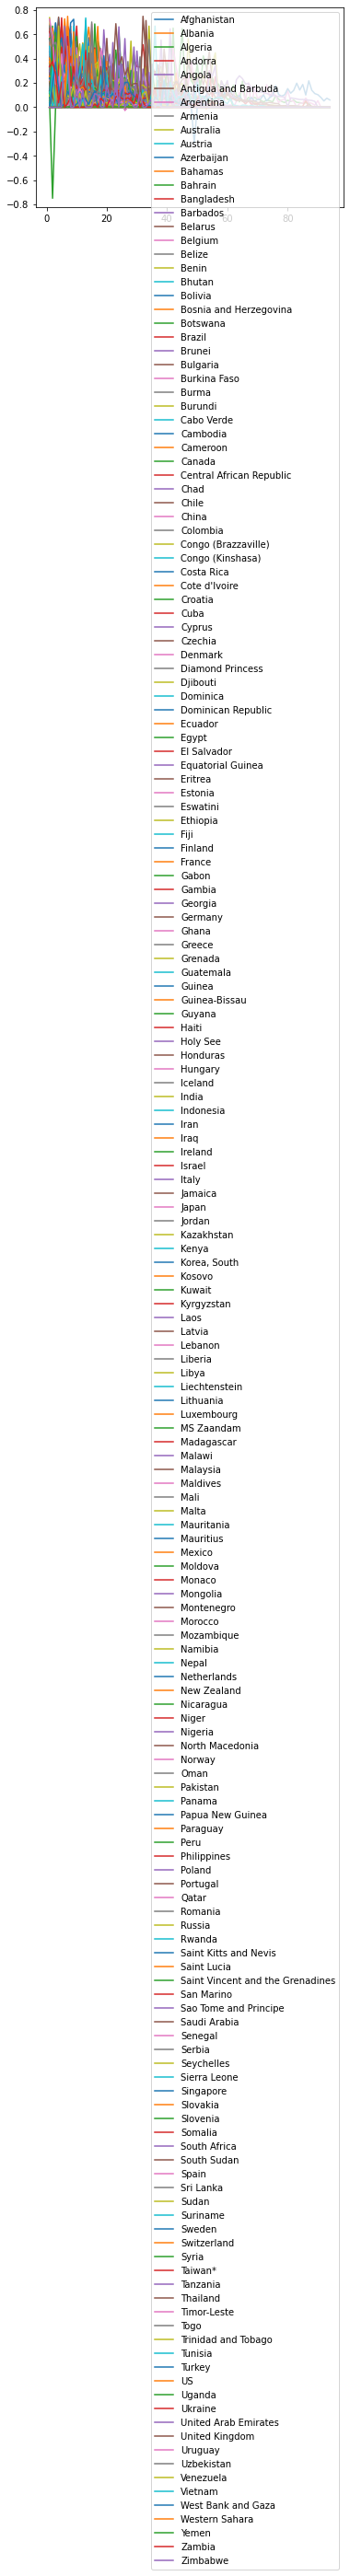

In [60]:
cases_after_cross_07499.pct_change().plot()

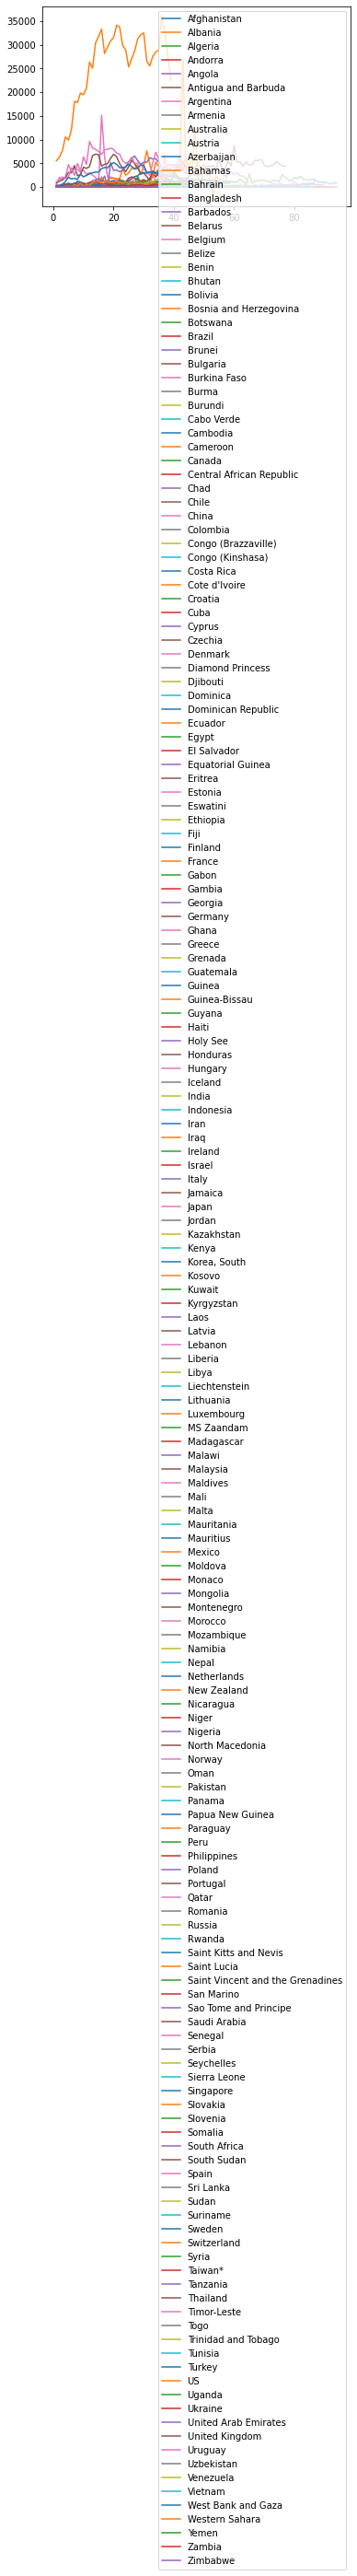

In [61]:
cases_after_cross_07499.diff().plot()

In [62]:
cases_after_cross_07499.dropna(axis=1)

,Singapore,Taiwan*
0,3.0,3.0
1,3.0,3.0
2,4.0,4.0
3,5.0,5.0
4,7.0,8.0
...,...,...
90,11178.0,427.0
91,12075.0,428.0
92,12693.0,429.0
93,13624.0,429.0


In [63]:
cases_after_cross_07499[cases_after_cross_07499.pct_change() < 0].dropna(axis=1)

""
0
1
2
3
4
...
90
91
92
93


## Code snippets

In [30]:
def process_JHU():
    
    dfs = {}
    
    # First, retrieve data
    for x in ['confirmed','deaths','recovered']:
        dfs[x + '_RAW'] = (pd.read_csv(TIME_SERIES_PATH + CSV_URL[upper(x)])
                           .rename(columns=_process_columns)
                          )
    
    for x in ['confirmed','deaths']:
        dfs[x + '_US_RAW'] = (pd.read_csv(TIME_SERIES_PATH + CSV_URL['US_' + upper(x)])
                              .rename(columns={'Long_': 'Long',
                                               'Country_Region': 'Country/Region',
                                               'Province_State': 'Province/State'
                                              })
                              .rename(columns=_process_columns)
                             )
        dfs[x + '_GLOBAL'] = _concatenate_US() # concatenate both US and global data
        dfs[x + '_COUNTRY'] = _country_level(dfs[x + '_GLOBAL']) # Generate country-level data
    
    def _country_level(df):
        '''Generate country-level dataframe of numbers from concatenated dataframes.
        '''
        temp_df = df.drop(['Lat', 'Long', 'Province/State'])
        temp_df = pd.pivot_table(temp_df,
                                 index=['Country/Region'],
                                 aggfunc=np.sum
                                )
        return temp_df
    
    def _concatenate_US(global_df, us_df):
        '''Concatenate both dataframes to return country-level information.
        Discards data more granular than the province/state level.
        '''
        temp_df = us_df.copy()
        excess_cols = set(us_df.columns) - set(global_df.columns)
        temp_df = temp_df.drop(excess_cols)
        return temp_df
    
    def _process_columns(col_name):
        try: 
            return dt.datetime.strptime(col_name, '%m/%d/%y').date()
        except ValueError:
            return col_name

In [31]:
[_process_columns(x) for x in df_confirmed.columns[4:]]

[datetime.date(2020, 1, 22),
 datetime.date(2020, 1, 23),
 datetime.date(2020, 1, 24),
 datetime.date(2020, 1, 25),
 datetime.date(2020, 1, 26),
 datetime.date(2020, 1, 27),
 datetime.date(2020, 1, 28),
 datetime.date(2020, 1, 29),
 datetime.date(2020, 1, 30),
 datetime.date(2020, 1, 31),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 3),
 datetime.date(2020, 2, 4),
 datetime.date(2020, 2, 5),
 datetime.date(2020, 2, 6),
 datetime.date(2020, 2, 7),
 datetime.date(2020, 2, 8),
 datetime.date(2020, 2, 9),
 datetime.date(2020, 2, 10),
 datetime.date(2020, 2, 11),
 datetime.date(2020, 2, 12),
 datetime.date(2020, 2, 13),
 datetime.date(2020, 2, 14),
 datetime.date(2020, 2, 15),
 datetime.date(2020, 2, 16),
 datetime.date(2020, 2, 17),
 datetime.date(2020, 2, 18),
 datetime.date(2020, 2, 19),
 datetime.date(2020, 2, 20),
 datetime.date(2020, 2, 21),
 datetime.date(2020, 2, 22),
 datetime.date(2020, 2, 23),
 datetime.date(2020, 2, 24),
 datetime.date(2020, 2,

## Population information

In [32]:
worldbank_pop_request = requests.get(WORLDBANK_POP_ZIP)
with zf.ZipFile(io.BytesIO(worldbank_pop_request.content), 'r') as wb_pop_zip:
    wb_pop_zip.extractall('tmp')

In [33]:
# to replace if possible
POPULATION_CSV = "API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv"
COUNTRY_METADATA_CSV = "Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv"

In [34]:
df_worldbank_pop = pd.read_csv("tmp/" + POPULATION_CSV, skiprows=2)
df_country_metadata = pd.read_csv("tmp/" + COUNTRY_METADATA_CSV)

FileNotFoundError: [Errno 2] File tmp/API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv does not exist: 'tmp/API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv'

In [ ]:
df_worldbank_pop